# Inter nella stagione 21/22

### Import Librerie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from scipy import stats, interpolate
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

try:
  from mplsoccer.pitch import Pitch, VerticalPitch
  from mplsoccer import PyPizza, Radar
except:
  !pip install mplsoccer
  from mplsoccer.pitch import Pitch, VerticalPitch
  from mplsoccer import PyPizza, Radar

### Funzioni importate da altri notebook

Le prime tre funzioni sono state prese dal notebook *'Esercitazione5_dati_evento.ipynb'* necessarie per estrarre informazioni dal dataset completo di dati evento. La quarta funzione è stata presa dal notebook *Lezione4_focus_dataviz.ipynb* per visualizzare dei Pizza Charts 

In [2]:
def eval_q(x):
    return eval(x.replace("null", "None"))
    
def get_numeric_q(x,qid):
    for l in x:
        if l['@attributes']['qualifier_id'] == str(qid):
            return float(l['@attributes']['value'])
    
def get_binary_q(x,qid):
    bl = []
    for l in x:
        if l['@attributes']['qualifier_id'] == str(qid):
            bl.append(True)
        else:
            bl.append(False)
    bl = np.asarray(bl)
    if bl.any():
        return True
    else:
        return False

#funzione presa dai notebook condivisi
#ho cambiato solo i parametri e messo l'input 'off' per decidere quale pizza plottare
def draw_pizza(t, t1name, df, off=1):
    #reorder columns
    cols = df.columns.to_list()
    if off ==0:
      params = ["inverse IRD", "inverse xGA", "forwardness", "%palle_lunghe","BDP", 'foul', 'ball_rec_3_campo',
                "ball rec m.c. avv.","palle perse propria m.c."]
    else:
      params = ['%Pass. Completati','Field Tilt','%Poss. Palla', "IPO", "xOVA", "npxG", 
              "Gol", "Tiri in porta", 'Tiri su Occ. Gol',
              'Drib. vincenti',"Travers. riusciti", "Cut Back riusciti", 
            'Triang. fatte']
    v1 = df.loc[t, metriche_rank].values
    # instantiate PyPizza class
    baker = PyPizza(
        params=params,                  # list of parameters
        # background_color="#15313D",     # background color
        straight_line_color="black",  # color for straight lines
        straight_line_lw=2,             # linewidth for straight lines
        last_circle_lw=2,               # linewidth of last circle
        last_circle_color="black",    # color of last circle
        other_circle_ls="-.",           # linestyle for other circles
        other_circle_lw=0               # linewidth for other circles
    )
    
    # plot pizza
    plt.rcParams.update({'font.size': 14})
    fig, ax = baker.make_pizza(
        v1,                     # list of values
        figsize=(8,8),             # adjust figsize according to your need
        kwargs_slices=dict(
            facecolor="steelblue",
            zorder=2, alpha = 0.7
        ),                          # values to be used when plotting slices
        kwargs_params=dict(va="center"),                          
        kwargs_values=dict(fontsize=0),
        kwargs_compare_values=dict(fontsize=0)
    )
    
    # add title

    if off ==0:
      plt.title("Altre metriche Inter", fontsize = 20, pad=20)
      plt.savefig("pizzadif.jpeg")
    else:
      plt.title("Metriche offensive Inter", fontsize = 20, pad=20)
      plt.savefig("pizzaoff.jpeg") 

### Caricamento Dataset


Per non caricare ogni volta i Datasets, ho connesso il notebook al mio Google drive, in modo da recuperarli ogni volta più velocemente.


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df_gioc = pd.read_csv('/content/drive/MyDrive/Football_Data_Intelligence/dati_completi_serieA_2021-22.csv')
df_part = pd.read_csv('/content/drive/MyDrive/Football_Data_Intelligence/dati_completi_serieA_2021-22_partite.csv')
df_event = pd.read_csv('/content/drive/MyDrive/Football_Data_Intelligence/soccerment_serieA_2021-22_allEvents.csv.zip')
df_ipo = pd.read_csv('/content/drive/MyDrive/Football_Data_Intelligence/SICS_SerieA_2021-22_OffensiveIndexTimetable.csv', sep=";")

### Map fra colori e squadre, fra id e squadre

In [5]:
#dizionario per collegare id squadre e colori
sq_col = {127: "blue",
456:"steelblue",
2182:"darkgreen",
125:"purple",
120:"red",
121:"darkred",
128:"dimgray",
135:"saddlebrown",
129:"deepskyblue",
2036:"gray",
137: "black",
123: "salmon",
126:"yellow",
1025:"brown",
124:"orangered",
695:"royalblue",
990:"crimson",
603:"aliceblue",
136: "gainsboro",
459:"cyan"}

rol_col = {'CB': "blue", 'FB':"darkgreen", 'DMC':"red", 'CM':"cyan", 'CAM':"crimson", 'WAM':"yellow", 'FW':"dimgray"}


In [6]:
#df per collegare id e nome squadra
squadre = df_event[["team_id","team"]].drop_duplicates()
#squadre = dict(zip(squadre.team_id, squadre.team))


### Andamento stagionale in termini di xG e xG against

In [7]:
def stagione(id, team, grafico = 0):
  '''
  obiettivo della funzione è avere per la squadra scelta una panoramica della stagione, partita per partita,
  sapendo per ogni partita il suo esito e come la squadra ha giocato in termini di xG, IPO,...

  input:
  id: id della squadra
  team: nome della squadra
  grafico: se voglio plottare l'andamento della stagione della squadra

  output
  team_df: dataframe in cui sono contenute per la squadra scelta, tutte le informazioni partita per partita,
          Ogni riga è una partita, e si ha come info l'esito, il possesso palla, field tilt, xG, xG against, IPO, IRD
  #ipo_medio: è la media dell'IPO durante la stagione per quella squadra
  #team_IPO_gol: è il rapporto fra l'IPO prodotto e i gol fatti nella stagione
  #ird_medio: è la media dell'IRD durante la stagione per quella squadra
  '''

  #lista con i gol della squadra
  team_gol = []

  #lista con i gol degli avversari
  opp_gol = []

  #lista con gli xG della squadra
  team_xG_part = []

  #lista con i xG degli avversari
  opp_xG_part = []

  #data in cui avvenuta la partita
  data = []

  #game id della partita
  game_id = []

  #field tilt
  field_tilt_sq = []

  #possesso palla
  possesso_sq = []

  #passaggi completati
  pass_compl_sq = []

  #per ogni matchday i
  for i in df_event.matchday.unique():

    #considero gli xG della squadra senza rigori, per sommarli tutti, anche i non tiri che non hanno xG, sostituisco i nan con 0
    #(potevo specificare il type_id)
    team_xG_part.append(sum(df_event[(df_event.team_id == id) & (df_event.matchday == i)& (~df_event.penalty)]["xG"].replace(np.nan,0)))

    #id dell'avversario. 
    opp_ = int(df_part[(df_part.team_id == id) & (df_part.matchday == i)]["opp_team_id"].iloc[0])

    #game id
    game_id.append(df_part[(df_part.team_id == id) & (df_part.matchday == i)]["game_id"].iloc[0])

    #xG dell'avversario considero gli xG della squadra senza rigori, per sommarli tutti, anche i non tiri che non hanno xG, sostituisco i nan con 0
    #(potevo specificare il type_id)
    opp_xG_part.append(sum(df_event[(df_event.team_id == opp_) & (df_event.matchday == i)& (~df_event.penalty)]["xG"].replace(np.nan,0)))

    #passaggi della squadra nel terzo offensivo
    pass_team = len(df_event[((df_event.team_id == id) & (df_event.type_id == 1) & (df_event.end_x >= 100*2./3) 
    & (df_event.x >= 100*2./3) & (df_event.matchday == i))])

    #passaggi della squadra avversaria nel terzo offensivo
    pass_opp = len(df_event[((df_event.team_id == opp_) & (df_event.type_id == 1) & (df_event.end_x >= 100*2./3) 
    & (df_event.x >= 100*2./3) & (df_event.matchday == i))])

    #field tilt
    field_tilt_sq.append(pass_team/(pass_team + pass_opp))

    #passaggi della squadra 
    pass_team = len(df_event[((df_event.team_id == id) & (df_event.type_id == 1) & (df_event.matchday == i))])

    #passaggi della squadra avversaria 
    pass_opp = len(df_event[((df_event.team_id == opp_) & (df_event.type_id == 1) & (df_event.matchday == i))])

    #possesso della squadra
    possesso_sq.append(pass_team/(pass_team + pass_opp))  

    #passaggi completati
    completed_pass_sq = (len(df_event[((df_event.team_id == id) & (df_event.type_id == 1) & (df_event.outcome == 1) & (df_event.matchday == i))]))

    #passaggi totali della squadra
    tot_pass_sq = (len(df_event[((df_event.team_id == id) & (df_event.type_id == 1) & (df_event.matchday == i))]))  

    #percentuale passaggi completati
    pass_compl_sq.append(completed_pass_sq/tot_pass_sq)

    #se la squadra sa giocando in casa
    try:
      #gol squadra. prendo l'ultimo valore il finale
      team_gol.append(df_event[(df_event.home_team_id == id) & (df_event.matchday == i)]["home_score"].iloc[-1])

      #gol avversario. prendo l'ultimo valore, il finale
      opp_gol.append(df_event[(df_event.home_team_id == id) & (df_event.matchday == i)]["away_score"].iloc[-1])

      #data
      data.append(df_event[(df_event.home_team_id == id) & (df_event.matchday == i)]["timestamp"].iloc[0])
      
    #se la squadra sa giocando in fuori casa
    except:
      team_gol.append(df_event[(df_event.away_team_id == id) & (df_event.matchday == i)]["away_score"].iloc[-1])
      opp_gol.append(df_event[(df_event.away_team_id == id) & (df_event.matchday == i)]["home_score"].iloc[-1])
      data.append(df_event[(df_event.away_team_id == id) & (df_event.matchday == i)]["timestamp"].iloc[0])

  #lista con esito della partita
  ris_team = []

  #punti guadagnati in ogni partita
  punti = []

  #per ogni partita
  for i in range(len(game_id)):

    #confronto i gol della squadra con l'avversario per sapere l'esito
    if team_gol[i] > opp_gol[i]:
      ris_team.append("W")
      punti.append(3)
    elif team_gol[i] < opp_gol[i]:
      ris_team.append("L")
      punti.append(0)
    else:
      ris_team.append("D")
      punti.append(1)

  #opponent è l'elenco delle 38 avversarie che ha affrontato la squadra
  opponent = df_event[df_event.team_id == id]["opp_team"]
  opponent = list(opponent.loc[opponent.shift() != opponent])

  #df_event con tutte le informazioni raccolte finora
  team_df = pd.DataFrame(list(zip(opponent,team_gol, opp_gol, ris_team, punti,
                                 team_xG_part, opp_xG_part, df_event.matchday.unique(), data, game_id, field_tilt_sq, possesso_sq, pass_compl_sq)), 
                        columns = ["Avversaria", f"Gol {team}", "Gol Avversaria", "Esito", "Punti",
                                   f"xG {team}", "xG Avversaria","matchday", "Data", "game_id", "Field Tilt", "Possesso Palla", "%Passaggi Completati"]).set_index("matchday")
  team_df = team_df.sort_values(by="Data", ascending=True).reset_index(drop=True)

  #per calcolare gli xP uso la sigmoide che ha come input la differenza degli xG)
  #team_df["xP"] = 3/(1 + np.exp(-(team_df[f"xG {team}"] - team_df["xG Avversaria"])))
  #xP = sum(3/(1 + np.exp(-(team_df[f"xG {team}"] - team_df["xG Avversaria"]))))

  #IPO squadra
  ipo_team = []

  #per tutti i match
  for j in df_ipo.matchDay.unique():

    #questo se perchè in un df_event è Inter e nell'altro è Internazionale. In df_ipo è INTER quindi ho usato .upper()
    if team != "Internazionale":

      #considero il valore massimo, il finale
      ipo_team.append(df_ipo[(df_ipo.matchDay == j) & (df_ipo.team==f"{team}".upper())]["OffensiveIndex"].max())

    else:
      ipo_team.append(df_ipo[(df_ipo.matchDay == j) & (df_ipo.team=="INTER")]["OffensiveIndex"].max())


  #IRD squadra
  ird = []
  match = []
  
  #per ogni match giocato nel campionato
  for k in df_ipo.match_name.unique():
    if team != "Internazionale":
    #se il team sta giocando quel match 
      if k.find(team.upper()) != -1:
        match.append(k)
    else:
      if k.find("INTER") != -1:
        match.append(k)


  for i in range(len(match)):
    if team != "Internazionale":
      #per calcolare IRD devo considerare semplicemente la squadra rivale
      ird.append(df_ipo[(team.upper() != df_ipo.team) & (df_ipo.match_name == match[i])]["OffensiveIndex"].max())

    else:
      ird.append(df_ipo[("INTER" != df_ipo.team) & (df_ipo.match_name == match[i])]["OffensiveIndex"].max())

  #aggiungo le metriche
  team_df["IPO"] = ipo_team
  team_df["IRD"] = ird

  #rapporto IPO/gol
  team_IPO_gol = sum(ipo_team)/sum(team_gol)

  #medie
  ipo_medio = np.mean(ipo_team)
  ird_medio = np.mean(ird)

  #per il grafico così da avere l'indice da 1 a 38
  team_df['indice'] = team_df.index + 1

  #codice preso dai notebook condivisi
  #creiamo nuove colonne con la media mobile
  #la std è così piccola perchè mi serviva evidenziare come l'inter ha dei minimi locali molto bassi
  #e dei massimi locali molto alti
  team_df['xG_rolling_gauss'] = team_df[f"xG {team}"].rolling(3, win_type = 'gaussian', center = True, min_periods = 1).mean(std = 0.6)
  team_df['xGA_rolling_gauss'] = team_df["xG Avversaria"].rolling(3, win_type = 'gaussian', center = True, min_periods = 1).mean(std = 0.6)

  #creiamo nuove colonne con l'interpolazione
  spl = interpolate.splrep(team_df.indice, team_df.xG_rolling_gauss)
  spl2 = interpolate.splrep(team_df.indice, team_df.xGA_rolling_gauss)

  x2 = np.linspace(1, 38, 1000)

  y = interpolate.splev(x2, spl)
  y2 = interpolate.splev(x2, spl2)

  #creiamo un grafico mostrando le due serie temporali
  #mostriamo i valori grezzi in trasparenza
  if grafico == 1:
    f, ax = plt.subplots(figsize = (14,5))
    #plt.plot(team_df.indice, team_df.xP, color = 'grey', alpha = 0.5, lw = 1, label = "xPoints")
    plt.plot(x2, y, label = 'xG a favore', lw = 4, color = 'steelblue')
    plt.plot(x2, y2, label = 'xG contro', lw = 4, color = 'tomato')

    plt.legend(bbox_to_anchor=(1.15, 1), fontsize = 15)
    ax.set_xticks(team_df.indice)
    ax.set_xticklabels(team_df.Avversaria, rotation=75, fontsize = 15)

    ax.set_yticklabels(np.arange(0.5,4.5,0.5),fontsize=15)
    ax.fill_between(x2, y, y2,alpha= 0.5, where=y >= y2,facecolor='steelblue')
    ax.fill_between(x2, y, y2, where=y <= y2, facecolor='tomato', alpha=0.5)

    ax2 = ax.twiny()
    ax2.set_xlim(ax.get_xlim())
    ax2.set_xticks(team_df.indice)
    ax2.set_xticklabels(team_df.Esito, fontsize = 15)
    for i in range(len(team_df.Esito)):
      if team_df.Esito.iloc[i] == 'W':
        ax2.get_xticklabels()[i].set_color("darkgreen")
      elif team_df.Esito.iloc[i]== 'D':
        ax2.get_xticklabels()[i].set_color("orange")
      else:
        ax2.get_xticklabels()[i].set_color("red")

    #just adding a point for each cup match of the Inter
    ax.text(3.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(6.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(8.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(11.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(13.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(16.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(23.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2)) 

    ax.text(26.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(27.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(20.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(21.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(24.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(32.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(36.5,ax.set_ylim(ax.get_ylim())[1], ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(40.8,ax.set_ylim(ax.get_ylim())[1]-1, ".", ha="center", va="center", rotation=45, size=3,
    bbox=dict(boxstyle="circle,pad=0.5 ", fc="blue", ec="blue", lw=2))

    ax.text(41.2,ax.set_ylim(ax.get_ylim())[1]-1.05,"Coppe", fontsize=15)

    ax.set_ylabel("Expected Goal", fontsize = 15)
    ax.set_title(f'{team}: xG a favore e xG contro', pad=20, fontsize = 20)

    plt.gca().xaxis.grid(True, alpha = 0.4)
    plt.tight_layout()
    plt.savefig("inter_trend.jpeg")
  return team_df, ipo_medio, team_IPO_gol, ird_medio

Nel calcolo delle medie mobili ho scelto come parametri *w=3* e *std=0.6* per far apprezzare il fatto che l'Inter ha avuto dei minimi locali importanti in alcune giornate. Se avessi ampliato la finestra o reso meno importanti le partite vicine non ci si sarebbe potuto rendere conto di questi minimi.

,Avversaria,Gol Inter,Gol Avversaria,Esito,Punti,xG Inter,xG Avversaria,Data,game_id,Field Tilt,Possesso Palla,%Passaggi Completati,IPO,IRD,indice,xG_rolling_gauss,xGA_rolling_gauss
0,Genoa,4,0,W,3,2.098837,0.802849,2021-08-21 16:43:41,2228908,0.715976,0.599244,0.886435,80.7,42.8,1,2.018098,0.769413
1,Verona,3,1,W,3,1.694306,0.635323,2021-08-27 18:50:30,2228917,0.461538,0.568786,0.778455,52.9,23.7,2,1.639813,0.814672
2,Sampdoria,2,2,D,1,0.962252,1.545756,2021-09-12 10:45:35,2228931,0.308219,0.480233,0.765133,44.3,51.1,3,1.565424,1.299647
3,Bologna,6,1,W,3,3.855497,0.976978,2021-09-18 16:13:32,2228937,0.410891,0.453922,0.889849,79.9,30.5,4,3.161046,1.170726
4,Fiorentina,3,1,W,3,2.574823,1.572704,2021-09-21 18:51:40,2228947,0.500000,0.472112,0.839662,85.5,43.5,5,2.871341,1.556469
5,Atalanta,2,2,D,1,3.076336,2.070850,2021-09-25 16:17:47,2228956,0.489691,0.490439,0.768349,98.9,62.6,6,2.686615,1.866612
6,Sassuolo,2,1,W,3,1.235473,1.341442,2021-10-02 18:52:26,2228972,0.549223,0.451411,0.791667,66.6,46.3,7,1.424579,1.511859
7,Lazio,1,3,L,0,0.531212,1.636305,2021-10-16 16:12:05,2228978,0.523256,0.482969,0.846293,44.4,54.0,8,0.690398,1.415716
8,Juventus,1,1,D,1,0.783722,0.605342,2021-10-24 19:00:09,2228988,0.483444,0.492278,0.796078,37.7,44.8,9,1.070648,0.774531
9,Empoli,2,0,W,3,2.760769,0.591268,2021-10-27 19:06:14,2228995,0.792079,0.686314,0.882096,82.8,28.0,10,2.357788,0.552561


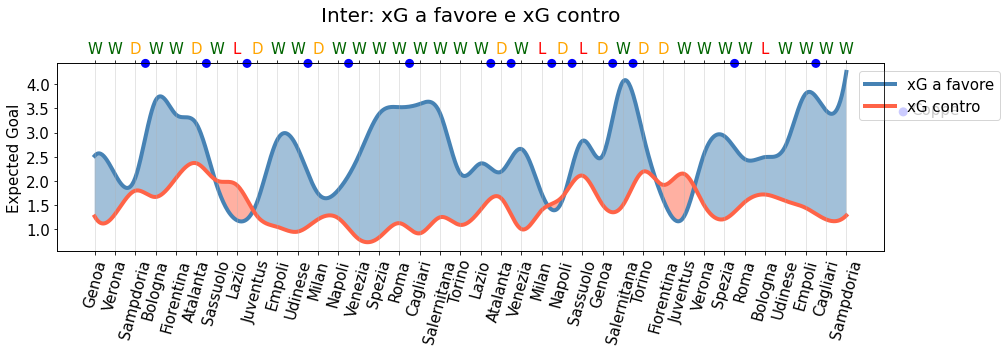

In [8]:
stagione_inter = stagione(127,"Inter", 1)[0]
stagione_inter

### Cross

In [9]:
#estraggo dal dataset i cross e gli autogol
df_event['Q'] = df_event.Q.apply(eval_q)
df_event['cross'] = df_event.Q.apply(get_binary_q, args = [2])
df_event['owngoal'] = df_event.Q.apply(get_binary_q, args = [28])

In [10]:
#df_event['assist'] = df_event.Q.apply(get_numeric_q, args = [55])

In [11]:
#i cross riusciti dell'Inter
dfi = df_event[((df_event.team_id == 127) & (df_event.type_id == 1) & (df_event.cross == 1) & (df_event.outcome == 1))]

In [12]:
#sommo per ogni squadra il numero di cross, gol di testa, ...
crosscross = df_part.groupby("team_id").sum()[['Cross', 'Gol di testa', "Cross riusciti", "Gol su Corner" ]]

#calcolo la % di cross riusciti
crosscross["%Cross riusciti"] = (crosscross["Cross riusciti"]/crosscross["Cross"])*100
crosscross = crosscross.sort_values(by="%Cross riusciti",ascending=False)

#riscalo la percentuale di cross riusciti per motivi grafici
scaler = MinMaxScaler((100,1000))
crosscross['%criusciti'] = scaler.fit_transform(crosscross["%Cross riusciti"].values.reshape(-1,1)).reshape(len(crosscross))

#faccio il merge per avere il nome delle squadre
crosscross = crosscross.merge(squadre, left_on=crosscross.index, right_on='team_id')

#le squadre che segnano maggiormente su corner
crosscross1 = crosscross.sort_values(by="Gol su Corner",ascending=False)[0:10]
crosscross1 = crosscross1.merge(squadre, on=['team_id','team'])


#per motivi grafici abbrevio il nome
abbrev = []
for i in crosscross1["team"]:
  abbrev.append(i[0:3])

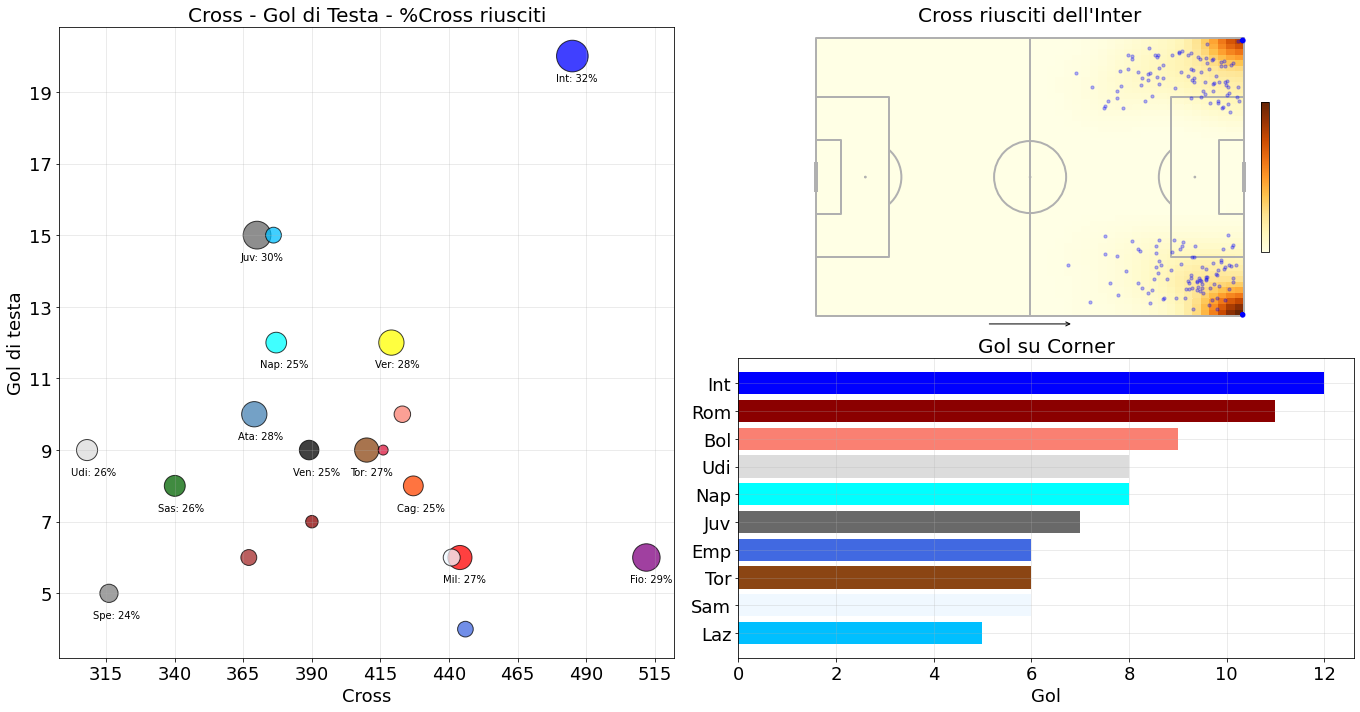

In [13]:
#grafico
fig = plt.figure(figsize=(19, 10))

plt.subplots_adjust(wspace= 0.10, hspace= 0.35)

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data = crosscross, x = 'Cross', y = 'Gol di testa',
                   s = '%criusciti',edgecolor = 'black', alpha = 0.75, color = crosscross.team_id.map(sq_col))

ax1.set_xlabel('Cross', fontsize = 18)
ax1.set_ylabel('Gol di testa', fontsize = 18)
ax1.set_xticklabels(np.arange(290,520,25),fontsize = 18)
ax1.set_yticklabels(np.arange(3,20,2), fontsize = 18)

for i in range(len(crosscross)-7):
  ax1.annotate(f'{crosscross.team.iloc[i][0:3]}: ' + '{:.0f}%'.format(crosscross["%Cross riusciti"].iloc[i]), 
               xy =([crosscross["Cross"].iloc[i]-6, crosscross["Gol di testa"].iloc[i] -0.7 ]), fontsize = 10)

ax1.set_title('Cross - Gol di Testa - %Cross riusciti', fontsize = 20)
ax1.grid(alpha=0.3)

ax2 = fig.add_subplot(2,2,2)
pitch = Pitch(pitch_type = 'opta', line_zorder = 1)
pitch.draw(ax = ax2)
bin_statistic = pitch.bin_statistic(dfi.x, dfi.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='YlOrBr', ax=ax2)
pitch.scatter(x = dfi.x,
              y = dfi.y,
              s = 10,
              color = 'blue',
              zorder = 10,
              alpha = 0.3,
              ax = ax2)
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01)
cbar.set_ticks([])
pitch.annotate("", xytext=(40, -3), xy=(60, -3), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax2)
ax2.set_title("Cross riusciti dell'Inter", fontsize = 20)

ax3 = fig.add_subplot(2,2,4)
ax3.barh(abbrev,crosscross1["Gol su Corner"], color = crosscross1.team_id.map(sq_col))
plt.gca().invert_yaxis()
ax3.set_title("Gol su Corner", fontsize = 20)
ax3.set_xticklabels(np.arange(0,14,2), fontsize = 18)
ax3.set_yticklabels(abbrev, fontsize = 18)
ax3.grid(alpha=0.3)
ax3.set_xlabel("Gol", fontsize = 18)
plt.tight_layout()
#plt.show()
plt.savefig("Cross-Gol.jpeg")



### xT

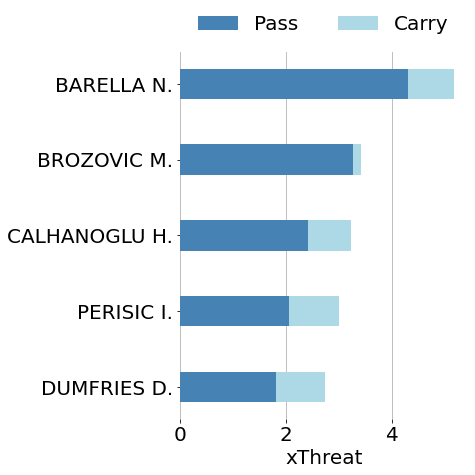

In [14]:
#grafico preso dai notebook condivisi, ma riadattato all'Inter
inter=df_part[df_part.team_id == 127]
inter_nomi = df_part[df_part.team_id == 127][["opta_id", "Giocatore"]].drop_duplicates()
inter_xT = inter.groupby("opta_id").sum()[[ 'xT',
 'xT_from_passes',
 'xT_from_carries']]
inter_gioc_xT = inter_nomi.merge(inter_xT, right_on=inter_xT.index, left_on="opta_id").sort_values(by="xT", ascending = False).head(5)
data = inter_gioc_xT[['xT_from_passes', 'xT_from_carries']].values
data_cum = data.cumsum(axis=1)
category_names = ['Pass', 'Carry']
category_colors = ['steelblue', 'lightblue']

labels = inter_gioc_xT.Giocatore.to_list()

plt.rcParams.update({'font.size': 20})
f, ax = plt.subplots(figsize=(7,7))
for i, (colname, color) in enumerate(zip(category_names, category_colors)):
    widths = data[:, i]
    starts = data_cum[:, i] - widths
    ax.barh(labels, widths, left=starts, height=0.4,
            label=colname, color=color, zorder = 99)

ax.legend(ncol=len(category_names),
          bbox_to_anchor=(0, 1),
          loc='lower left',
          shadow = None,
          edgecolor = 'none',
          facecolor = 'none')

ax.set_xlabel('xThreat')
ax.invert_yaxis()
sns.despine(fig = f, top = True, bottom = True, left = True, right = True)
ax.xaxis.grid(True)
plt.tight_layout()
plt.savefig("xT.jpeg")

In [15]:
soluzioni = df_part.groupby("team_id").sum()[[
 'Cross',
 'Cross riusciti',
 'Cross vincenti',
 'Traversoni',
 'Traversoni riusciti',
 'Traversoni vincenti',
 'Cut Back',
 'Cut Back riusciti',
 'Cut Back vincenti']]
soluzioni = soluzioni.merge(squadre, left_on=soluzioni.index, right_on='team_id')
soluzioni1= soluzioni.sort_values(by="Traversoni", ascending=False).reset_index(drop=True)[0:10]
soluzioni2= soluzioni.sort_values(by="Cut Back", ascending=False).reset_index(drop=True)[0:10]

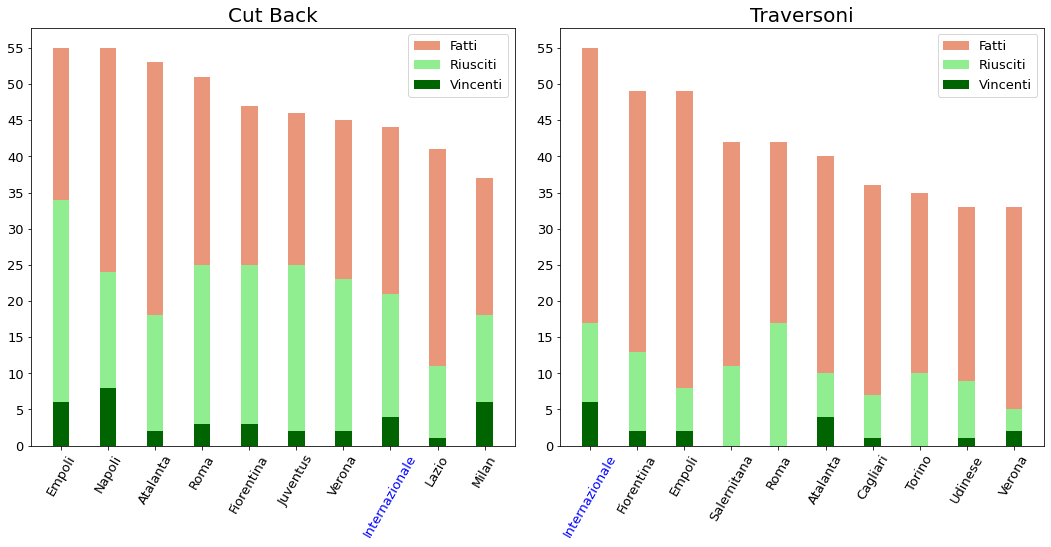

In [16]:
#grafico
width = 0.35       # the width of the bars: can also be len(x) sequence

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,8))

ax[0].bar(soluzioni2["team"], soluzioni2["Cut Back"], width, label='Fatti', color = 'darksalmon')
ax[0].bar(soluzioni2["team"], soluzioni2["Cut Back riusciti"], width,
       label='Riusciti', color = 'lightgreen')
ax[0].bar(soluzioni2["team"], soluzioni2["Cut Back vincenti"], width,
       label='Vincenti', color = 'darkgreen')

ax[0].set_yticks(np.arange(0,60,5))
ax[0].set_yticklabels(np.arange(0,60,5), fontsize = 13)
ax[0].set_xticklabels(soluzioni2["team"], rotation = 60, fontsize = 13)
ax[0].set_title('Cut Back', fontsize = 20)
ax[0].get_xticklabels()[7].set_color("blue")
ax[0].legend(fontsize=13)

ax[1].bar(soluzioni1["team"], soluzioni1["Traversoni"], width, label='Fatti', color = 'darksalmon')
ax[1].bar(soluzioni1["team"], soluzioni1["Traversoni riusciti"], width,
       label='Riusciti', color = 'lightgreen')
ax[1].bar(soluzioni1["team"], soluzioni1["Traversoni vincenti"], width,
       label='Vincenti', color = 'darkgreen')

ax[1].set_yticks(np.arange(0,60,5))
ax[1].set_yticklabels(np.arange(0,60,5), fontsize = 13)
ax[1].set_xticklabels(soluzioni1["team"], rotation = 60, fontsize = 13)
ax[1].set_title('Traversoni', fontsize = 20)
ax[1].legend(fontsize=13)
ax[1].get_xticklabels()[0].set_color("blue")
plt.tight_layout()
plt.savefig("cutback.jpeg")

### Dominio territoriale, Aggressività,...


Per calcolare le successive metriche ho seguito le seguenti definizioni:

**Field Tilt**: 'Il Field Tilt si calcola prendendo per ogni partita i passaggi nel terzo offensivo delle due squadre (riusciti o meno), e calcolando la frazione del totale risultante di ciascuna squadra. Field tilt di 70% per me significa che nelle mie partite, fra tutti i passaggi nel terzo offensivo che avvengono (sia miei che degli avversari), il 70% sono miei.'

**Possesso palla**: 'Il possesso palla si può approssimare nello stesso modo, semplicemente estendendo la definizione di field tilt a tutto il campo invece di limitarsi al terzo offensivo. Non corrisponderà sempre a un possesso palla basato sul minutaggio, ma è un'approssimazione molto vicina.'

**BDP**: 'By computing the team’s pass completion rate for each match, we can compare it with the team’s average rate, and compute a percentage difference. If we then switch the point of view and look at the opposing team, average these differences weighting them by the opponent’s average pass accuracy and change the sign, this tells us how successful their pressing is in disrupting their opponents’ buildup phase.' *https://soccerment.com/measuring-pressing-success-buildup-disruption-percentage-bdp/* 

I valori ottenuti sono leggermenti diversi da quelli presenti nel sito di Soccerment ma, c'è una discrepanza anche fra nel numero di passaggi fatti dalle squadre. Queste differenze sono limitate. 

**Forwardness**: Sono tutti i passaggi che hanno un punto di partenza più arretrato del punto di arrivo

**Palle lunghe**: Sono tutti quei passaggi che partono dal terzo difensivo e arrivano nel terzo offensivo

In [17]:
def altre_metr(df):
  '''
  obiettivo della funzione è avere per ogni squadra il BDP, forwardness, falli, palle rec,... 
  complessivi della stagione

  input
  df: il df evento per evento

  output
  squadre_data: è un df in cui ogni riga è una squadra e le colonne sono le varie metriche come
  BDP, falli, %passaggi completati,...
  '''

  #inizializzazione
  #conterranno i valori delle diverse metriche squadra per squadra
  #ogni elemento sarà una lista di 38 valori
  tot_pass = []
  completed_pass = []
  avversario = []
  pass_acc = []
  palle_lunghe_perc = []
  forwardness = []
  foul = []
  ball_rec = []
  field_tilt = []
  
  #per ogni squadra
  for j in df.team_id.unique():

    #inizializzazione
    #sono delle liste che avranno 38 elementi, uno per ogni partita della squadra j
    #ad ogni step del ciclo vengono re-inizializzate
    tot_pass_sq = []
    completed_pass_sq = []
    avversario_sq = []
    field_tilt_sq = []
    possesso_sq = []

    #per ogni partita
    for i in df.matchday.unique(): 

      #passaggi completati
      completed_pass_sq.append(len(df[((df.team_id == j) & (df.type_id == 1) 
      & (df.outcome == 1) & (df.matchday == i))]))

      #passaggi totali
      pass_team_tot = len(df[((df.team_id == j) & (df.type_id == 1) & (df.matchday == i))])
      tot_pass_sq.append(pass_team_tot)
      
      #nome avversario
      avversario_sq.append(df[((df.team_id == j) & (df.matchday == i))]["opp_team"].unique()[0])

      #passaggi nel terzo offensivo
      pass_team = len(df[((df.team_id == j) & (df.type_id == 1) & (df.end_x >= 100*2./3) 
    & (df.x >= 100*2./3) & (df.matchday == i))])
      
      #id avversario
      opp_team_id = int(df[((df.team_id == j) & (df.matchday == i))]["opp_team_id"].iloc[0])

      #passaggi avversario nel terzo offensivo
      pass_opp = len(df[((df.team_id == opp_team_id) & (df.type_id == 1) & (df.end_x >= 100*2./3) 
    & (df.x >= 100*2./3) & (df.matchday == i))])
      
      #field tilt
      field_tilt_sq.append(pass_team/(pass_team + pass_opp))
      
      #passaggi avversario
      pass_opp = len(df[((df.team_id == opp_team_id) & (df.type_id == 1) & (df.matchday == i))])

      #possesso palla
      possesso_sq.append(pass_team_tot/(pass_team_tot + pass_opp))      

    #faccio la media del field tilt e del possesso palla nella stagione
    field_tilt.append([np.mean(field_tilt_sq) * 100, np.mean(possesso_sq) * 100, j])

    #percentuale palle lunghe
    palle_lunghe_perc.append(len(df[(df.team_id == j) & (df.type_id ==1) & (df.outcome==1) 
    & (df.x < 100/3) & (df.end_x >= 100*2./3)])/sum(completed_pass_sq))

    #forwardness 
    forwardness.append(len(df[(df.team_id == j) & (df.type_id ==1) & (df.outcome==1) & (df.x < df.end_x)])/sum(completed_pass_sq))

    #fouls
    foul.append(len(df[(df.team_id == j) & (df.type_id ==4) & (df.outcome==0)]))

    #ball recovery
    ball_rec.append(len(df[(df.team_id == j) & (df.type_id ==49) & (df.x > 2*100/3)]))

    #immagazzino i valori trovati partita per partita
    tot_pass.append(tot_pass_sq)
    completed_pass.append(completed_pass_sq)
    avversario.append(avversario_sq)

  #da lista a df
  field_tilt = pd.DataFrame(field_tilt, columns = ["Field Tilt","%Possesso Palla", "team_id"])


  perc_pass = []
  average = []
  diff = []

  #per ogni squadra
  for i in range(len(df.team_id.unique())):

    #percentuale passaggi completati partita per partita
    perc_pass.append(np.array(completed_pass[i])/np.array(tot_pass[i]))
    #average.append(sum(completed_pass[i])/sum(np.array(tot_pass[i])))

    #media percentuale passaggi completati
    average.append(np.mean(perc_pass[i]))

    #vettore lungo 38, differenza fra la percentuale di passaggi completati e la media
    diff.append(perc_pass[i] - average[i])

  #faccio un unico dataset aggiungendo i passaggi completati
  squadre_data = list(zip(df.team.unique(),df.team_id.unique(), average))
  squadre_data = pd.DataFrame(squadre_data, columns = ["Squadra", "team_id", "%Passaggi Completati"])
  squadre_data = squadre_data.merge(field_tilt, on='team_id')


  bdp = []

  #per ogni squadra
  for k in df.team_id.unique():

    #avversari, solo che ho tantissimi duplicati
    avversario = df[df.team_id == k]["opp_team"]

    #sarà lungo 38, con gli avversari sfidati ripetuti solo una volta
    avversario= avversario.loc[avversario.shift() != avversario]
    avversario = list(avversario)

    prodotto = []

    #per ogni partita
    for i in range(len(avversario)):

      #id avversario
      id_avv = int(squadre[squadre.team==avversario[i]]["team_id"])

      #nome avversario
      nome_avv = squadre[squadre.team==avversario[i]]["team"].iloc[0]

      #faccio il prodotto fra (la differenza fra percentuale di passaggi completati e la media con quell'avversario) 1 fattore
      #per (la %percentuale di passaggi completati di quell'avversario) 2 fattore
      prodotto.append((diff[df.team_id.unique().tolist().index(id_avv)][i])*squadre_data[squadre_data.Squadra == nome_avv]["%Passaggi Completati"].iloc[0])
    
    #faccio la somma delle percentuali dei passaggi completati, eccetto che per la mia squadra (non si è mai giocato contro se stessi)
    #poi si moltiplica per due perchè c'è andata e ritorno, i pesi sono 38 e non 19, ma sono a due a due uguali
    somma_pesi = sum(squadre_data[squadre_data["Squadra"] != squadre[squadre.team_id == k]["team"].iloc[0]]["%Passaggi Completati"])*2

    #cambio il segno, e faccio la media pesata (pesi sono la percentuale di passaggi completati)
    bdp.append((-(sum(prodotto)/somma_pesi))*100)

  #aggiungo le metriche già calcolate
  squadre_data["BDP"] = bdp
  squadre_data["%palle_lunghe"] = np.array(palle_lunghe_perc) * 100
  squadre_data["forwardness"] = forwardness
  squadre_data["foul"] = foul
  squadre_data["ball_rec_3_campo"] = ball_rec

  #ordino per BDP
  squadre_data.sort_values(by="BDP", ascending=False).reset_index(drop=True)
  return squadre_data

In [18]:
final_df = []

#per ogni squadra
for i in range(len(squadre)):

  #conosco il suo andamento stagionale partita per partita
  funzione = stagione(squadre["team_id"].iloc[i], squadre["team"].iloc[i])

  #creo un df riassuntivo stagionale in cui ogni riga è una squadra e 
  final_df.append([squadre["team_id"].iloc[i], squadre["team"].iloc[i], funzione[1], funzione[2], funzione[3]])
final_df = pd.DataFrame(final_df)
final_df = final_df.rename(columns={0:"team_id", 1:"team", 2:"IPO", 3:"IPO/Gol fatti", 4:"IRD"})


#punti_pesati = []

#peso i punti fatti con le altre avversarie, i pesi sono l'IPO medio dalle avversarie
punti_pesati_IPO = []

#per ogni squadra
for i in range(len(squadre)):
  df = stagione(squadre.team_id.iloc[i], squadre.team.iloc[i])[0]

  #quanti punti fa contro ogni avversaria
  df = pd.DataFrame(df.groupby("Avversaria").sum()["Punti"]).reset_index()
  df = df.merge(final_df, right_on="team", left_on="Avversaria")
  #punti_pesati.append([np.average(d.Punti, weights=d["xP"])*19, squadre.team.iloc[i]])

  #media pesata rispetto agli IPO
  punti_pesati_IPO.append([np.average(df.Punti, weights=df["IPO"])*19,squadre.team.iloc[i]])

punti_pes = pd.DataFrame(punti_pesati_IPO, columns = ["Punti Pesati IPO", "team"])
final_df = final_df.merge(punti_pes, on="team")


In [19]:
squadre_data = altre_metr(df_event)
final_df = final_df.merge(squadre_data, on="team_id")

### Pizza Charts

In [ ]:
altre_metriche = df_part.groupby("team_id").sum()[["Cross riusciti", "Traversoni riusciti", "Cut Back riusciti",
                                        'Dribbling vincenti', 'Triangolazioni fatte', "Gol", "Tiri in porta",
                                        'xg_against_team', "opxA", "xT", 'Tiri su Occasione Gol','Propria metà campo',
                                        "Recupera palla", "xOVA", "npxG"]].reset_index()
final_df = final_df.merge(altre_metriche, on="team_id")

In [ ]:
metriche = ['%Passaggi Completati','Field Tilt','%Possesso Palla', "IPO", "xOVA", "npxG", 
              "Gol", "Tiri in porta", 'Tiri su Occasione Gol','Dribbling vincenti',
              "Traversoni riusciti", "Cut Back riusciti", 
            'Triangolazioni fatte']
metriche_rank = []
for m in metriche:
  m2 = m+'_rank'
  metriche_rank.append(m2)
  if m2 not in final_df.columns:
    final_df[m2] = 100*final_df[m].rank(pct = True)

In [ ]:
final_df = final_df.rename(columns={"'%Passaggi Completati'": "%Pass. completati", "Triangolazioni fatte": "Triang. fatte",
                         'Tiri su Occasione Gol': 'Tiri su Occ. Gol', 'Dribbling vincenti': 'Drib. vincenti',
                         '%Possesso Palla': "%Poss. Palla", "Traversoni riusciti": "Travers. riusciti",
                         })

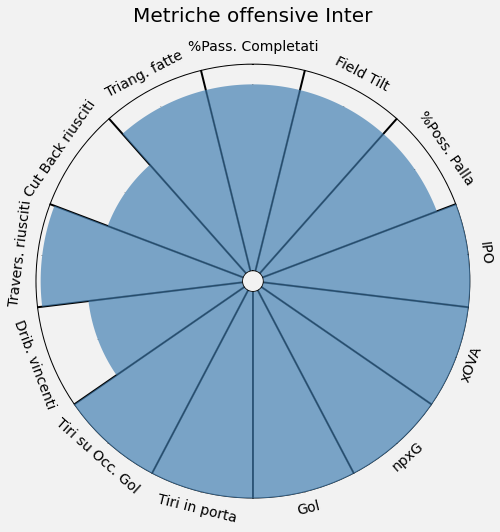

In [24]:
draw_pizza(8, 'Inter', final_df)

In [25]:
final_df["inverse xGA"] = 1/final_df["xg_against_team"]
final_df["inverse IRD"] = 1/final_df["IRD"]

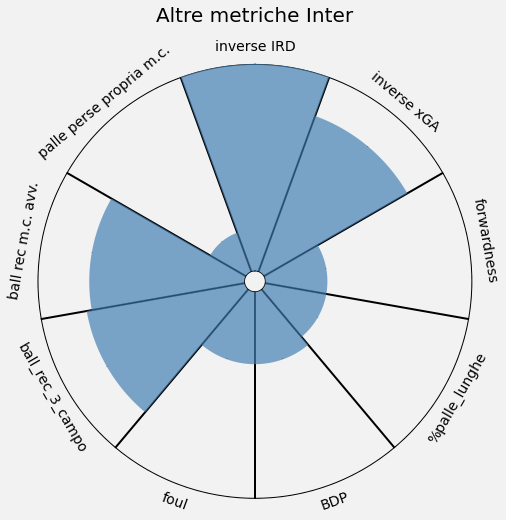

In [26]:
metriche = ["inverse IRD", "inverse xGA", "forwardness", "%palle_lunghe","BDP", 'foul', 'ball_rec_3_campo',"Recupera palla",
            "Propria metà campo"]
metriche_rank = []
for m in metriche:
  m2 = m+'_rank'
  metriche_rank.append(m2)
  if m2 not in final_df.columns:
    final_df[m2] = 100*final_df[m].rank(pct = True)

final_df = final_df.rename(columns={"Propria metà campo": "palle perse propria m.c.",
                                    "Recupera palla": "ball rec m.c. avv."
                         })

draw_pizza(8, 'Inter', final_df, 0)

In [27]:
squadre_ = ['Napoli', 'Fiorentina','Internazionale', 'Lazio',  'Atalanta','Milan',"Torino", 'Juventus', 'Roma', "Verona"]
prime_dieci = squadre_data[squadre_data["Squadra"].isin(squadre_)]

In [28]:
prime_dieci = prime_dieci.sort_values(by="%Possesso Palla", ascending=False).reset_index(drop=True)

In [29]:
#giocatori dell'Inter che tirano maggiormente da fuori area
#df_part[df_part.team_id == 127][["opta_id", "Giocatore"]].drop_duplicates()
#df_part[df_part.team_id == 127].groupby("opta_id").sum()["Tiri fuori area"]

### Shot Selection

In [30]:
#raggruppo per squadra e sommo le varie tipologie di tiro in base alla posizione
shot_sel = df_part.groupby("team_id").sum()[['Tiri da area',
 'Tiri da area piccola',
 'Tiri fuori area']]

#merge per avere nome delle suadre
shot_sel = shot_sel.merge(squadre, on='team_id')

In [31]:
#tiri fatti dall'Inter
df_tiri = df_event[((df_event.team_id == 127) & (~df_event.penalty) & 
                    ((df_event.type_id == 13) | (df_event.type_id == 14) |(df_event.type_id == 15) | (df_event.type_id == 16)))]

#gol fatti dall'Inter                
df_gol = df_event[((df_event.team_id == 127) & (df_event.type_id == 16) & (~df_event.penalty))]

In [32]:
#tiri non vincenti in porta
df_tiri_inporta = df_event[((df_event.team_id == 127) & (~df_event.penalty) & (df_event.type_id == 15))]

#tiri non vincenti fuori dalla porta
df_tiri_fuori = df_event[((df_event.team_id == 127) & (~df_event.penalty) & ((df_event.type_id == 13) | (df_event.type_id == 14)))]

#tiri non vincenti
df_tiri_nonvinc = df_event[((df_event.team_id == 127) & (~df_event.penalty) & ((df_event.type_id == 13) | (df_event.type_id == 14) | (df_event.type_id == 15)))]


In [33]:
#raggruppo per squadra e sommo le varie tipologie di gol
gol = df_part.groupby("team").sum()[['Gol',
 'Gol da area',
 'Gol da area piccola',
 'Gol fuori area',
 'Gol su rigore']]

#inizializzazione
gol_area_p =[]
gol_fuori_area_p =[]
gol_areapic_p =[]
gol_area =[]
gol_fuori_area =[]
gol_areapic =[]

#per ogni squadra top10
for i in squadre_:
  #percentual gol fatti in area 
  gol_area_p.append((gol[(gol.index ==i)]["Gol da area"][0]- gol[(gol.index ==i)]["Gol su rigore"][0])/(gol[(gol.index ==i)]["Gol"][0]- gol[(gol.index ==i)]["Gol su rigore"][0])*100)

  #percentual gol fatti fuori area  
  gol_fuori_area_p.append(gol[(gol.index ==i)]["Gol fuori area"][0]/(gol[(gol.index ==i)]["Gol"][0]- gol[(gol.index ==i)]["Gol su rigore"][0])*100)

  #percentuale gol fatti area piccola  
  gol_areapic_p.append(gol[(gol.index ==i)]["Gol da area piccola"][0]/(gol[(gol.index ==i)]["Gol"][0]- gol[(gol.index ==i)]["Gol su rigore"][0])*100)

  #gol area
  gol_area.append(int(gol[(gol.index ==i)]["Gol da area"][0]- gol[(gol.index ==i)]["Gol su rigore"][0]))

  #gol fuori area
  gol_fuori_area.append(int(gol[(gol.index ==i)]["Gol fuori area"][0]))

  #gol area piccola
  gol_areapic.append(int(gol[(gol.index ==i)]["Gol da area piccola"][0]))

In [34]:
#raggruppo per squadra e sommo i tiri da area, fuori area e tiri totali
tiri = df_part.groupby("team_id").sum()[["Tiri da area", "Tiri fuori area", "Tiri"]]

#tiri per partita
tiri = tiri/38

#merge per avere nome della squadra
tiri = tiri.merge(squadre, on='team_id')

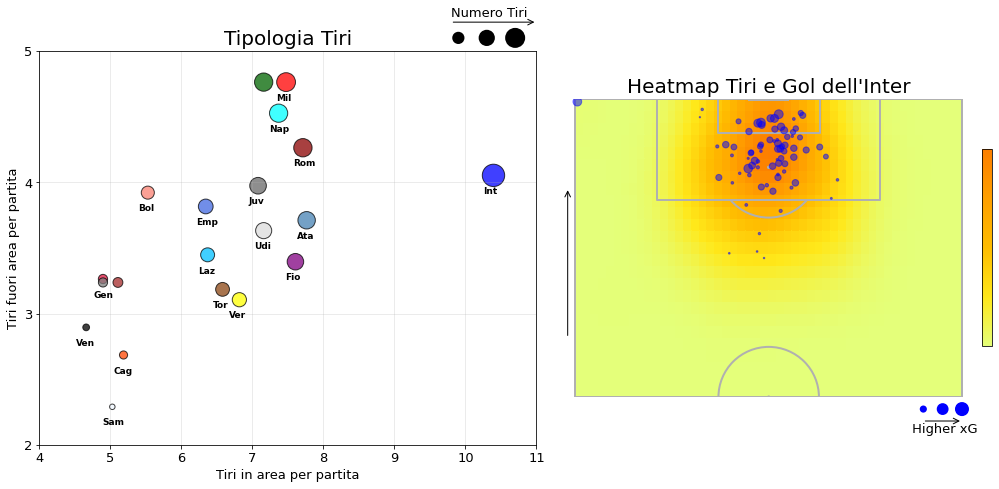

In [35]:
#grafico
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))

plt.subplots_adjust(wspace= 0.05, hspace= 0.35)

pitch = VerticalPitch(pitch_type = 'opta', line_zorder = 1, half = True)
pitch.draw(ax = ax[1])

bin_statistic = pitch.bin_statistic(df_tiri.x, df_tiri.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='Wistia', ax=ax[1])
pitch.scatter(x = df_gol.x,
              y = df_gol.y,
              s = df_gol["xG"]*100,
              color = 'blue',
              zorder = 10,
              alpha = 0.5,
              marker='o',
              ax = ax[1])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01)
cbar.set_ticks([])
pitch.annotate("", xytext=(60, 102), xy=(85, 102), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax[1])
ax[1].set_title("Heatmap Tiri e Gol dell'Inter", fontsize = 20)
ax[1].set_ylim(50,100)

scaler = MinMaxScaler((30,500))
tiri['tiri_scaled'] = scaler.fit_transform(tiri["Tiri"].values.reshape(-1,1)).reshape(len(tiri))
ax[0].scatter(tiri["Tiri da area"], tiri["Tiri fuori area"],
            s = tiri["tiri_scaled"], edgecolor = 'black', alpha = 0.75, color = tiri.team_id.map(sq_col))
ax[0].set_yticks(np.arange(2,6))
ax[0].set_xticks(np.arange(4,12))
ax[0].set_yticklabels(np.arange(2,6), fontsize = 13)
ax[0].set_xticklabels(np.arange(4,12), fontsize = 13)

ax[0].set_xlabel("Tiri in area per partita", fontsize = 13)
ax[0].set_ylabel("Tiri fuori area per partita", fontsize = 13)
ax[0].set_title("Tipologia Tiri", fontsize = 20)
for i in range(len(tiri)-3):
  ax[0].annotate(f'{tiri.team.iloc[i][0:3]}', 
               xy =([tiri["Tiri da area"].iloc[i]-0.14, tiri["Tiri fuori area"].iloc[i]-0.14]), fontsize =9, weight = 'bold')
ax[0].text(10.7, 5.1, "a", ha="center", va="center", rotation=45, size=15,
    bbox=dict(boxstyle="circle,pad=0.10", fc="black", ec="black", lw=2))
ax[0].text(10.3, 5.1, "a", ha="center", va="center", rotation=45, size=12,
    bbox=dict(boxstyle="circle,pad=0.05", fc="black", ec="black", lw=2))
ax[0].text(9.9, 5.1, "a", ha="center", va="center", rotation=45, size=10,
    bbox=dict(boxstyle="circle,pad=0.01", fc="black", ec="black", lw=2))

ax[0].annotate("", xytext=(9.8, 5.22), xy=(11, 5.22), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False)

ax[0].text(9.8, 5.26,"Numero Tiri", fontsize=13)

ax[1].text(0, 48, ".", ha="center", va="center", rotation=45, size=10, color = "b",
    bbox=dict(boxstyle="circle,pad=0.10", fc="b", ec="b", lw=2))
ax[1].text(5, 48, ".", ha="center", va="center", rotation=45, size=8, color = "b",
    bbox=dict(boxstyle="circle,pad=0.05", fc="b", ec="b", lw=2))
ax[1].text(10, 48, ".", ha="center", va="center", rotation=45, size=5, color = "b",
    bbox=dict(boxstyle="circle,pad=0.01", fc="b", ec="b", lw=2))

ax[1].annotate("", xytext=(0, 46), xy=(10, 46), xycoords = 'data', arrowprops=dict(arrowstyle="<-", color = 'black'), annotation_clip = False)

ax[1].text(14,44," Higher xG", fontsize=13)

ax[0].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("shot selection.jpeg")

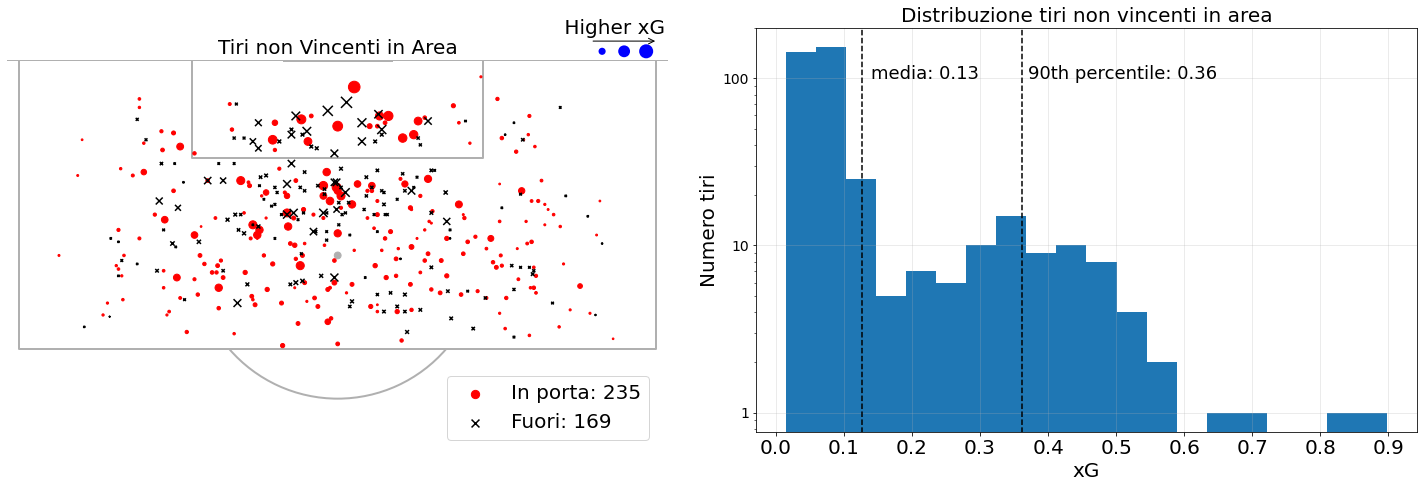

In [36]:
#tiri in porta calciati dentro l'area
df_tiri_inporta1 = df_tiri_inporta[(df_tiri_inporta.x > 83) & (df_tiri_inporta.y < 78.8) & (df_tiri_inporta.y > 21.2)]

#tiri fuori dallo specchio calciati dentro l'area
df_tiri_fuori1 = df_tiri_fuori[(df_tiri_fuori.x > 83) & (df_tiri_fuori.y < 78.8) & (df_tiri_fuori.y > 21.2)]

#tutti i tiri non vincenti
tiri_non_vinc = pd.concat([df_tiri_inporta1, df_tiri_fuori1])

#grafico
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,7))

plt.subplots_adjust(wspace= 0.05, hspace= 0.35)

pitch = VerticalPitch(pitch_type = 'opta', line_zorder = 1)
pitch.draw(ax = ax[0])

pitch.scatter(x = df_tiri_inporta1.x,
              y = df_tiri_inporta1.y,
              s = df_tiri_inporta1["xG"]*150,
              #s= 10,
              color = 'red',
              zorder = 10,
              alpha = 1,
              marker = 'o',
              label = "In porta: "+ str(len(df_tiri_inporta1)),
              ax = ax[0])


pitch.scatter(x = df_tiri_fuori1.x,
              y = df_tiri_fuori1.y,
              s = df_tiri_fuori1["xG"]*150,
              #s=10,
              color = 'black',
              zorder = 10,
              alpha = 1,
              marker = 'x',
              label = "Fuori: " + str(len(df_tiri_fuori1)),
              ax = ax[0])


#pitch.annotate("", xytext=(60, 105), xy=(85, 105), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax)
ax[0].set_title("Tiri non Vincenti in Area", fontsize = 20)
ax[0].legend(bbox_to_anchor = (0.65,0.1), fontsize = 20)
ax[0].set_ylim(80,100)
ax[0].set_xlim([20,80])

tiri_non_vinc = pd.concat([df_tiri_inporta1, df_tiri_fuori1])
ax[1].hist(tiri_non_vinc["xG"], bins = 20)
ax[1].set_yscale("log")
from matplotlib.ticker import ScalarFormatter
for axis in [ax[1].yaxis]:
    axis.set_major_formatter(ScalarFormatter())
ax[1].set_xticks(np.arange(0,1.1,0.1))
ax[1].set_ylabel("Numero tiri", fontsize = 20)
ax[1].set_xticklabels(np.round(np.arange(0,1.1,0.1),1), fontsize = 20)
ax[1].set_xlabel("xG", fontsize = 20)
ax[1].set_title("Distribuzione tiri non vincenti in area", fontsize = 20)
ax[1].grid(alpha=0.3)
ax[1].vlines(stats.scoreatpercentile(tiri_non_vinc["xG"], 90), 0, 200,linestyles='dashed')
ax[1].vlines(np.mean(tiri_non_vinc["xG"]), 0, 200,linestyles='dashed')
ax[1].set_ylim([0,200])
ax[1].text(0.14,100, "media: "+ str(round(np.mean(tiri_non_vinc["xG"]),2)), fontsize = 18)
ax[1].text(0.37,100, "90th percentile: "+ str(round(stats.scoreatpercentile(tiri_non_vinc["xG"], 90),2)), fontsize = 18)

ax[0].text(78, 100.5, ".", ha="center", va="center", rotation=45, size=10, color = "b",
    bbox=dict(boxstyle="circle,pad=0.10", fc="b", ec="b", lw=2))
ax[0].text(76, 100.5, ".", ha="center", va="center", rotation=45, size=8, color = "b",
    bbox=dict(boxstyle="circle,pad=0.05", fc="b", ec="b", lw=2))
ax[0].text(74, 100.5, ".", ha="center", va="center", rotation=45, size=5, color = "b",
    bbox=dict(boxstyle="circle,pad=0.01", fc="b", ec="b", lw=2))

ax[0].annotate("", xytext=(73, 101.1), xy=(79, 101.1), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False)

ax[0].text(70,101.5," Higher xG", fontsize=20)
plt.tight_layout()
plt.savefig("Inarea.jpeg")

In [37]:
#i seguenti due grafici non sono presenti nella tesina finale

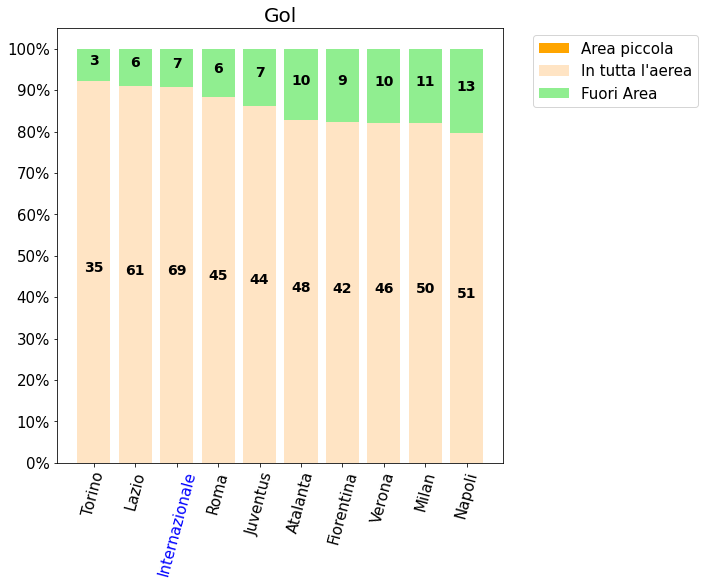

In [38]:
plt.figure(figsize=(8,8))
ytic = []
for i in np.arange(0,110,10):
  ytic.append(f'{i}%')


gol = pd.DataFrame(list(zip(squadre_, gol_area, gol_fuori_area,gol_areapic,gol_area_p, gol_fuori_area_p,gol_areapic_p)), columns=["squadra", "area","fuori","piccola","area_gol","fuori_gol","piccola_gol"]).sort_values(by="area_gol",ascending=False)
plt.bar(gol.squadra, gol.piccola_gol, label = "Area piccola", color= "orange")
plt.bar(gol.squadra, gol.area_gol, label = "In tutta l'aerea",color="bisque")
plt.bar(gol.squadra, gol.fuori_gol,label="Fuori Area", bottom=gol.area_gol, color="lightgreen")

plt.title("Gol", fontsize=20)
plt.xticks(np.arange(0,10,1), rotation=75, fontsize=15)
plt.yticks(np.arange(0,110,10), ytic, fontsize=15)
plt.legend(bbox_to_anchor=(1.05,1), fontsize=15)
plt.gca().get_xticklabels()[2].set_color("blue")


for i in range(len(gol)):
      #plt.annotate(gol.piccola.iloc[i], xy =([i, (gol.piccola_gol.iloc[i]/2)]), weight = "bold", ha='center')
      plt.annotate(gol.area.iloc[i], xy =([i, gol.area_gol.iloc[i]/2]), weight = "bold", ha='center')
      plt.annotate(gol.fuori.iloc[i], xy =([i, gol.area_gol.iloc[i] + gol.fuori_gol.iloc[i]/2]), weight = "bold", ha='center')

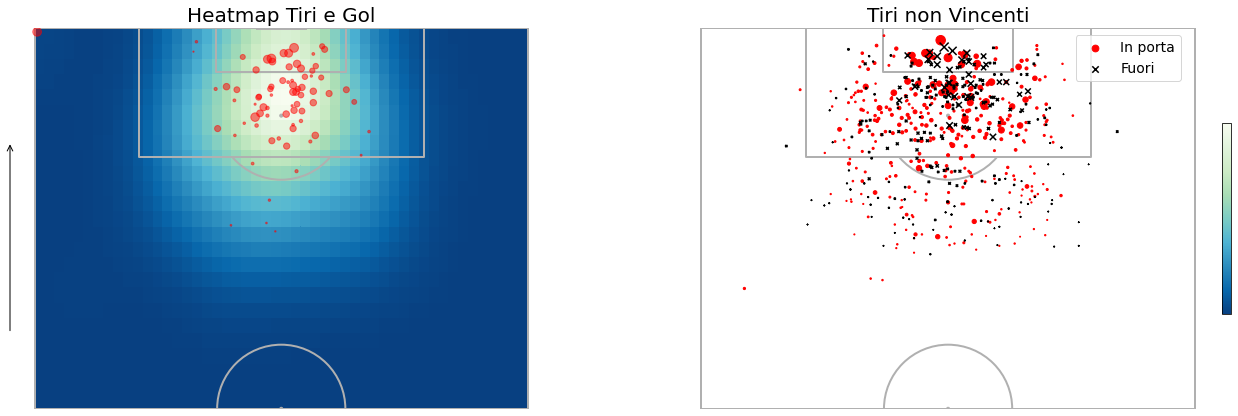

In [39]:
#df_tiri_inporta = df_event[((df_event.team_id == 127) & (~df_event.penalty) & ((df_event.type_id == 15) | (df_event.type_id == 16)))]
df_tiri_inporta = df_event[((df_event.team_id == 127) & (~df_event.penalty) & (df_event.type_id == 15))]
df_tiri_fuori = df_event[((df_event.team_id == 127) & (~df_event.penalty) & ((df_event.type_id == 13) | (df_event.type_id == 14)))]


f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,6))

plt.subplots_adjust(wspace= 0.05, hspace= 0.35)

pitch = VerticalPitch(pitch_type = 'opta', line_zorder = 1, half = True)
pitch.draw(ax = ax[0])

bin_statistic = pitch.bin_statistic(df_tiri.x, df_tiri.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='GnBu_r', ax=ax[0])
pitch.scatter(x = df_gol.x,
              y = df_gol.y,
              s = df_gol["xG"]*100,
              color = 'red',
              zorder = 10,
              alpha = 0.5,
              ax = ax[0])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01)
cbar.set_ticks([])
pitch.annotate("", xytext=(60, 105), xy=(85, 105), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax[0])
ax[0].set_title("Heatmap Tiri e Gol", fontsize = 20)
ax[0].set_ylim(50,100)


pitch.draw(ax = ax[1])
pitch.scatter(x = df_tiri_inporta.x,
              y = df_tiri_inporta.y,
              s = df_tiri_inporta["xG"]*100,
              #s= 10,
              color = 'red',
              zorder = 10,
              alpha = 1,
              marker = 'o',
              label = "In porta",
              ax = ax[1])

pitch.scatter(x = df_tiri_fuori.x,
              y = df_tiri_fuori.y,
              s = df_tiri_fuori["xG"]*100,
              #s=10,
              color = 'black',
              zorder = 10,
              alpha = 1,
              marker = 'x',
              label = "Fuori",
              ax = ax[1])


#pitch.annotate("", xytext=(60, 105), xy=(85, 105), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax[1])
ax[1].set_title("Tiri non Vincenti", fontsize = 20)
ax[1].legend(bbox_to_anchor = (0.95,1))
ax[1].set_ylim(50,100)
plt.tight_layout()
plt.show()

### xG Performance

In [40]:
#raggruppo per giocatore, ruolo e squadra e prendo le metriche dei gol, xG e tiri..
gioc = df_part.groupby(["Giocatore", "soccRole", "team_id"]).sum()[["npxG", "Gol", "Gol su rigore", "mins_played", "Tiri"]]

#non considero i gol segnati su rigore
gioc["npGol"] = gioc["Gol"] - gioc["Gol su rigore"]

#xG performance, differenza fra npGol e npxG
gioc["xG_perf"] = gioc["npGol"] - gioc["npxG"]

#normalizzo per 90 minuti
gioc["Tiri_P90"] = gioc["Tiri"] / (gioc.mins_played/90)

#considero solo i giocatori con più di 90 minuti e più di 20 tiri
gioc = gioc[(gioc.mins_played >= 900) & (gioc.Tiri >= 20)]

#raggruppo per ruolo e considero la media della xG performance
gioc = gioc.reset_index()
medie = gioc.groupby("soccRole").mean()["xG_perf"]

#filtro i giocatori dell'inter
gioc1 = gioc[gioc.team_id == 127]
gioc1 = gioc1.sort_values("soccRole", ascending = False)

#associo un colore per ogni ruolo
gioc1["color"] = gioc1.soccRole.map(rol_col)

In [41]:
#raggruppo per squadra
occ = df_part.groupby("team_id").sum()[['Passaggi Chiave in area',"Gol da area","Gol su rigore"]]

#non considero i gol segnati su rigore
occ["area"] = occ["Gol da area"] - occ["Gol su rigore"]

#stardizzo i gol segnati in area e l'IPO
scaler = MinMaxScaler((100,1000))
occ['gol_scaled'] = scaler.fit_transform(occ["area"].values.reshape(-1,1)).reshape(len(occ))
final_df['IPO_scaled'] = scaler.fit_transform(final_df["IPO"].values.reshape(-1,1)).reshape(len(final_df))

#ordinamento utile per il grafico
occ = occ.sort_values('gol_scaled', ascending=False)
final_df = final_df.sort_values(by=["npxG"], ascending = False)

#aggiungo le colonne al dataset complessivo 
final_df = final_df.merge(occ, on='team_id')

#considero tutti i gol tranne quelli segnati in area
final_df["npGol"] = final_df["Gol"] - final_df["Gol su rigore"]

In [42]:
#codice preso dai notebook condivisi
X = final_df['npxG'].values.reshape(-1,1)
y = final_df['npGol'].values

#definiamo l'oggetto regressore
regr = LinearRegression()

# facciamo il training con la funzione fit
regr.fit(X, y)

# creiamo un array su cui fare le predizioni
xarr = np.linspace(final_df['npxG'].min(), final_df['npxG'].max(), 1000)

# facciamo le predizioni con la funzione pred
y_pred = regr.predict(xarr.reshape(-1,1))

In [43]:
#xG per shot
xG_shot = []

#per ogni squadra
for i in final_df.team_id:

  #non considero i rigori, prendo l'xG di tutti i tiri e faccio la media
  xG_shot.append([np.mean(df_event[((df_event.team_id == i) & (~df_event.penalty) & 
                    ((df_event.type_id == 13) | (df_event.type_id == 14) |(df_event.type_id == 15) | (df_event.type_id == 16)))]["xG"]), i])

In [44]:
#xG performance, differenza fra npGol e npxG
final_df["xG_perf"] = final_df["npGol"] - final_df["npxG"]

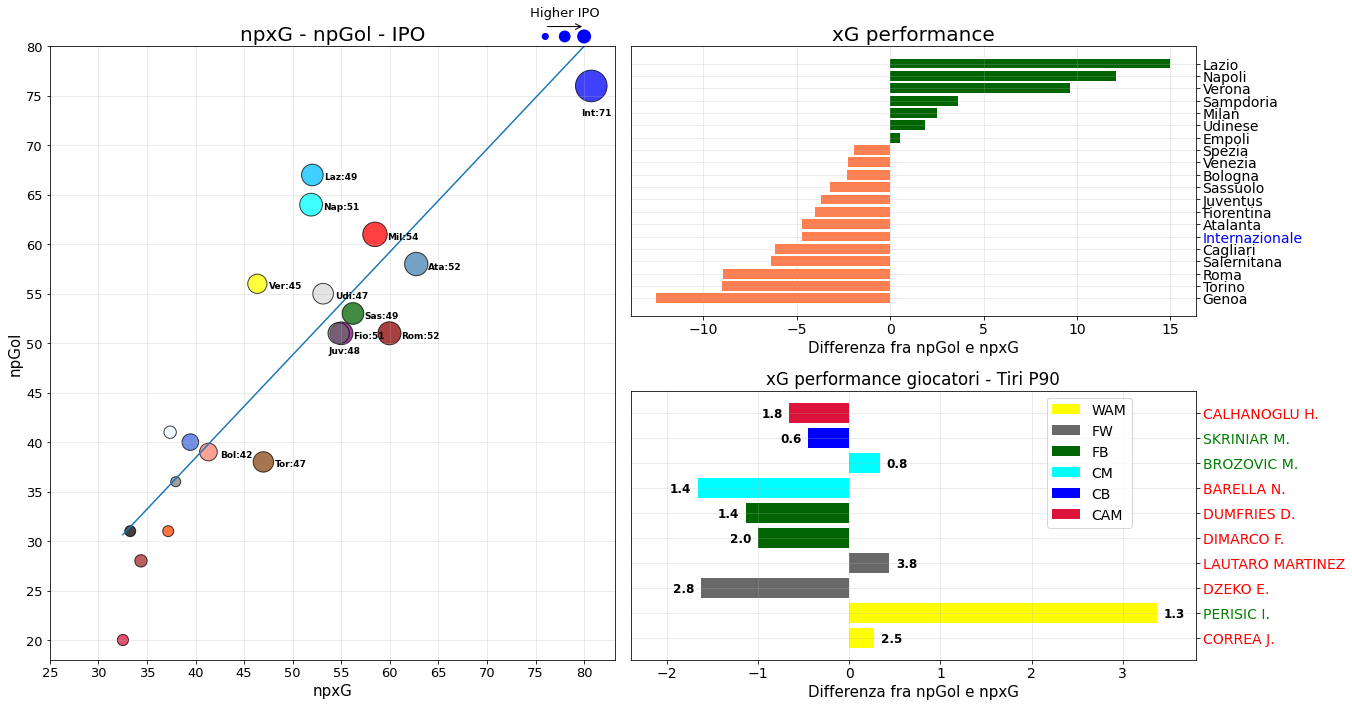

In [45]:
#grafico
fig = plt.figure(figsize=(19, 10))

plt.subplots_adjust(wspace= 0.10, hspace= 0.35)

ax1 = fig.add_subplot(1,2,1)
ax1.scatter(data = final_df, x = 'npxG', y = 'npGol',
                   s = 'IPO_scaled', edgecolor = 'black', alpha = 0.75, color = final_df.team_id.map(sq_col))

ax1.plot(xarr, y_pred)
ax1.set_xlabel('npxG', fontsize = 15)
ax1.set_ylabel('npGol', fontsize = 15)
ax1.grid(alpha=0.3)

ax1.annotate(f'{final_df.team.iloc[6][0:3]}:' + '{:.0f}'.format(final_df["IPO"].iloc[6]), 
              xy =([final_df["npxG"].iloc[6]-1, final_df["npGol"].iloc[6] -2]), fontsize =9, weight='bold')

ax1.annotate(f'{final_df.team.iloc[0][0:3]}:' + '{:.0f}'.format(final_df["IPO"].iloc[0]), 
              xy =([final_df["npxG"].iloc[0]-1, final_df["npGol"].iloc[0] -3]), fontsize =9, weight='bold')

for i in np.concatenate([np.arange(1,6), np.arange(7,13)]):
  ax1.annotate(f'{final_df.team.iloc[i][0:3]}:' + '{:.0f}'.format(final_df["IPO"].iloc[i]), 
               xy =([final_df["npxG"].iloc[i]+1.2, final_df["npGol"].iloc[i]-0.5]), fontsize =9, weight='bold')
  
ax1.set_title('npxG - npGol - IPO', fontsize = 20)
ax1.set_yticks(np.arange(5,85,5))
ax1.set_yticklabels(np.arange(5,85,5), fontsize = 13)
ax1.set_xticks(np.arange(25,85,5))
ax1.set_xticklabels(np.arange(25,85,5), fontsize = 13)
ax1.set_ylim([18,80])
ax1.text(80, 81, ".", ha="center", va="center", rotation=45, size=10, color = "b",
    bbox=dict(boxstyle="circle,pad=0.10", fc="b", ec="b", lw=2))
ax1.text(78, 81, ".", ha="center", va="center", rotation=45, size=8, color = "b",
    bbox=dict(boxstyle="circle,pad=0.05", fc="b", ec="b", lw=2))
ax1.text(76, 81, ".", ha="center", va="center", rotation=45, size=5, color = "b",
    bbox=dict(boxstyle="circle,pad=0.01", fc="b", ec="b", lw=2))
ax1.annotate("", xytext=(76, 82), xy=(80, 82), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False)

ax1.text(74,83," Higher IPO", fontsize=13)

ax2 = fig.add_subplot(2,2,2)
final_df.loc[0, "color"] = 'blue'
final_df = final_df.sort_values('xG_perf')
mask1 = final_df.xG_perf >= 0
mask2 = final_df.xG_perf < 0

b2 = ax2.barh(final_df.team[mask2], final_df.xG_perf[mask2], color = "coral")
ax2.barh(final_df.team[mask1], final_df.xG_perf[mask1], color = "darkgreen")
ax2.yaxis.set_label_position('right')
ax2.yaxis.tick_right()
#ax[1].bar_label(b2, padding=3, fmt = '%.2f')
plt.gca().get_yticklabels()[5].set_color("blue")
ax2.grid(alpha=0.3)
ax2.set_title("xG performance", fontsize = 20)
ax2.set_xlabel("Differenza fra npGol e npxG", fontsize = 15)

ax3 = fig.add_subplot(2,2,4)
for i in range(len(gioc1)):
  ax3.barh(gioc1.Giocatore.iloc[i], width = gioc1.xG_perf.iloc[i], color = gioc1.color.iloc[i], label = gioc1.soccRole.iloc[i])

  if gioc1.xG_perf.iloc[i] < 0:
    plt.annotate("{:.1f}".format(gioc1.Tiri_P90.iloc[i]), xy =([gioc1.xG_perf.iloc[i]-0.19, i-0.2]), weight = "bold",ha='center', fontsize = 12)
  else: 
    plt.annotate("{:.1f}".format(gioc1.Tiri_P90.iloc[i]), xy =([gioc1.xG_perf.iloc[i]+0.19, i-0.2]), weight = "bold",ha='center', fontsize = 12)

  ax3.yaxis.set_label_position('right')
  ax3.yaxis.tick_right()
  if gioc1.xG_perf.iloc[i] > medie[gioc1.soccRole.iloc[i]]:
    plt.gca().get_yticklabels()[i].set_color("green")
  else:
    plt.gca().get_yticklabels()[i].set_color("red")

#funzione presa da stackoverflow per non avere duplicati nella legenda
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), bbox_to_anchor = (0.9,1))
    
legend_without_duplicate_labels(ax3)
ax3.set_xlim([-2.4,3.8])
ax3.set_xlabel("Differenza fra npGol e npxG", fontsize = 15)
ax3.grid(alpha=0.3)
ax3.set_title("xG performance giocatori - Tiri P90")
plt.tight_layout()
plt.savefig("npxGol.jpeg")

In [46]:
#codice preso dai notebook condivisi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
regr = LinearRegression()

#training su dataset train
regr.fit(X_train, y_train)

#prediction su dataset test
y_pred = regr.predict(X_test)

#calcoliamo R2
r2 = r2_score(y_test, y_pred)
print("Il coefficiente di determinazione vale ", round(r2,2))                                                   

Il coefficiente di determinazione vale  0.72


In [47]:
#codice preso dai notebook condivisi
X = final_df['Passaggi Chiave in area'].values.reshape(-1,1)
y = final_df['Tiri su Occ. Gol'].values

#definiamo l'oggetto regressore
regr = LinearRegression()

# facciamo il training con la funzione fit
regr.fit(X, y)

# creiamo un array su cui fare le predizioni
xarr = np.linspace(occ['Passaggi Chiave in area'].min(), occ['Passaggi Chiave in area'].max(), 1000)

# facciamo le predizioni con la funzione pred
y_pred = regr.predict(xarr.reshape(-1,1))

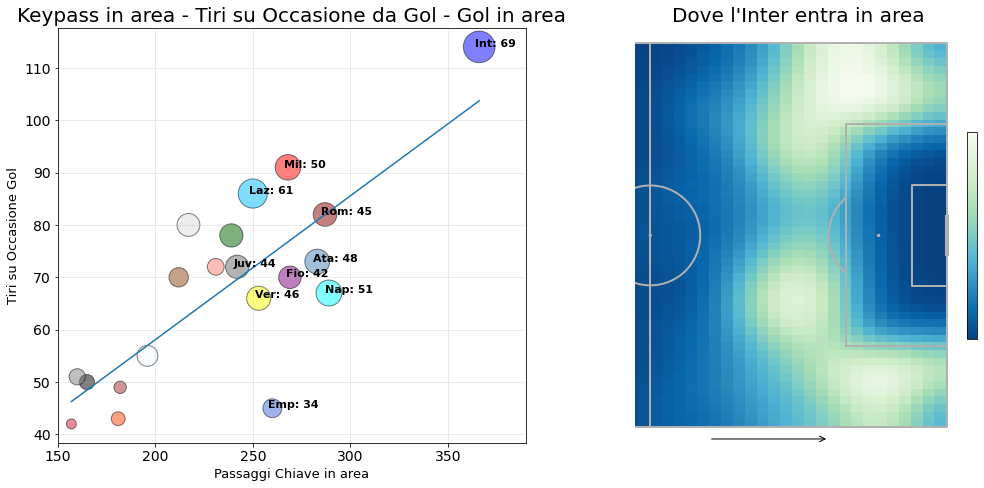

In [48]:
#ordino per passaggi chiave in area
final_df = final_df.sort_values(by=["Passaggi Chiave in area"], ascending = False)

#grafico
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))

plt.subplots_adjust(wspace= 0.05, hspace= 0.35)

ax[0].scatter(data = final_df, x = 'Passaggi Chiave in area', y = 'Tiri su Occ. Gol', s = 'gol_scaled',
            edgecolor = 'black', alpha = 0.5, color = final_df.team_id.map(sq_col))
ax[0].plot(xarr, y_pred)
ax[0].set_ylabel('Tiri su Occasione Gol', fontsize =13)
ax[0].set_xlabel('Passaggi Chiave in area', fontsize = 13)
#ax[0].set_xticks(fontsize=13)
#ax[0].set_yticks(fontsize=13)
for i in range(len(final_df)-10):
  ax[0].annotate(f'{final_df.team.iloc[i][0:3]}: '+ '{:.0f}'.format(final_df["area"].iloc[i]),
               xy =([final_df['Passaggi Chiave in area'].iloc[i]-2, final_df['Tiri su Occ. Gol'].iloc[i]]), fontsize =11, weight = 'bold')
ax[0].set_xlim(150,390)
ax[0].set_title("Keypass in area - Tiri su Occasione da Gol - Gol in area", fontsize = 20)
ax[0].grid(alpha=0.3)

df_event['ibox_start'] = ((df_event.x >= 83) & ((df_event.y >=21.2) & (df_event.y <= 78.9)))
df_event['ibox_end'] = ((df_event.end_x >= 83) & ((df_event.end_y >=21.2) & (df_event.end_y <= 78.9)))
dfpa = df_event[(df_event.team_id == 127) & (df_event.type_id == 1) & (df_event.outcome == 1) & ~df_event.corner_taken & ~df_event.free_kick_taken & df_event.ibox_end & ~df_event.ibox_start]

pitch = Pitch(pitch_type = 'opta', line_zorder = 1, half=True)
pitch.draw(ax = ax[1])
bin_statistic = pitch.bin_statistic(dfpa.x, dfpa.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='GnBu_r', ax=ax[1])

cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01)
cbar.set_ticks([])
pitch.annotate("", xytext=(60, -3), xy=(80, -3), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax[1])
ax[1].set_title("Dove l'Inter entra in area", fontsize = 20)
plt.tight_layout()
plt.savefig("area.jpeg")
#plt.show()

In [49]:
#codice preso dai notebook condivisi
#la funzione restituisce quattro array, due per la X e due per la y. Impostiamo una test size del 30%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
regr = LinearRegression()

#training su dataset train
regr.fit(X_train, y_train)

#prediction su dataset test
y_pred = regr.predict(X_test)

#calcoliamo R2
r2 = r2_score(y_test, y_pred)

print("Il coefficiente di determinazione vale ", round(r2,2))

Il coefficiente di determinazione vale  0.66


'Il coefficiente di determinazione **$R^{2}$** valuta sostanzialmente la correlazione fra la nostra predizione e il valore reale della variabile target per i dati test.' Entrambi i fit mostrano un buon valore di **$R^{2}$** possiamo quindi pensare che il nostro fit sia buono. 

### Fase difensiva Inter

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

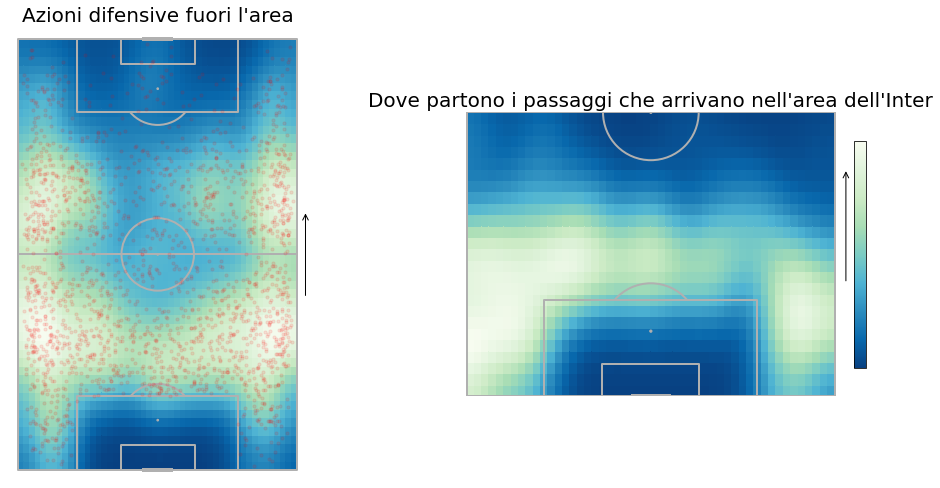

In [50]:
#il primo grafico è preso dai notebook condivisi
defTypes = [4, 7, 8, 10, 12, 45, 74]
df_event['ibox_start'] = ((df_event.x >= 83) & ((df_event.y >=21.2) & (df_event.y <= 78.9)))
df_event['ibox_end'] = ((df_event.end_x >= 83) & ((df_event.end_y >=21.2) & (df_event.end_y <= 78.9)))
dfd = df_event[(df_event.team_id == 127) & df_event.type_id.isin(defTypes) & ((df_event.type_id != 4) | (df_event.outcome == 0))]
dfpa = df_event[(df_event.opp_team_id == 127) & (df_event.type_id == 1) & (df_event.outcome == 1) & ~df_event.corner_taken & ~df_event.free_kick_taken & df_event.ibox_end & ~df_event.ibox_start]
dfd = dfd[(dfd.x > 17) | ((dfd.y < 21.2) | (dfd.y > 78.9))]
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))

plt.subplots_adjust(wspace= 0.05, hspace= 0.35)
pitch = VerticalPitch(pitch_type = 'opta', line_zorder = 1)
pitch.draw(ax = ax[0])

bin_statistic = pitch.bin_statistic(dfd.x, dfd.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='GnBu_r', ax=ax[0])
pitch.scatter(x = dfd.x,
              y = dfd.y,
              s = 10,
              color = 'red',
              zorder = 10,
              alpha = 0.1,
              ax = ax[0])
cbar = plt.colorbar(pcm, shrink = 0.5, pad = 0.01)
cbar.set_ticks([])
pitch.annotate("", xytext=(40, -3), xy=(60, -3), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax[0])
ax[0].set_title("Azioni difensive fuori l'area", fontsize = 20)

#inversione coordinate
dfpa['x'] = 100 - dfpa.x
dfpa['y'] = 100 - dfpa.y
dfpa['end_x'] = 100 - dfpa.end_x
dfpa['end_y'] = 100 - dfpa.end_y
pitch = VerticalPitch(pitch_type = 'opta', line_zorder = 1)
pitch.draw(ax = ax[1])
bin_statistic = pitch.bin_statistic(dfpa.x, dfpa.y, statistic='count', bins=(50,50))
bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 3)
pcm = pitch.heatmap(bin_statistic, cmap='GnBu_r', ax=ax[1])

cbar.set_ticks([])
pitch.annotate("", xytext=(20, -3), xy=(40, -3), xycoords = 'data', arrowprops=dict(arrowstyle="->", color = 'black'), annotation_clip = False, ax = ax[1])
ax[1].set_title("Dove partono i passaggi che arrivano nell'area dell'Inter", fontsize = 20)
ax[1].set_ylim(0,50)
plt.tight_layout()
plt.savefig("azionidif.jpeg")

### Big Match

In [51]:
def punti(id, sq):
  #obiettivo della funzione è trovare le metriche avanzate come xG, IPO, IRD, 
  #della squadra data in input
  #contro squadre definite top e contro le altre squadre

  #prendo il dataset partita per partita della squadra interessata
  df = stagione(id, sq)[0]

  #inizializzazione
  es = []
  es_flop = []
  xG_top = []
  xG_flop = []
  ipo_top = []
  ipo_flop = []
  ird_top = []
  ird_flop = []

  #per ogni squadra top
  for i in squadre_:

    #per tutte le partite
    for j in range(len(df)):

      #se l'avversaria appartiene alle top 
      if i == df.Avversaria.iloc[j]:

        #esito della partita
        es.append(df.Esito.iloc[j])

        #xG
        xG_top.append(df["xG "+sq].iloc[j])

        #IPO
        ipo_top.append(df["IPO"].iloc[j])

        #IRD
        ird_top.append(df["IRD"].iloc[j])

  #per ogni squadra flop
  for i in squadre_flop:

    #per ogni partita
    for j in range(len(df)):

      #se l'avversaria non è top
      if i == df.Avversaria.iloc[j]:

        #come prima
        es_flop.append(df.Esito.iloc[j])
        xG_flop.append(df["xG "+sq].iloc[j])
        ipo_flop.append(df["IPO"].iloc[j])
        ird_flop.append(df["IRD"].iloc[j])

  #quanti punti fatti contro le top     
  punti_top = es.count("W") * 3 + es.count("D") 

  #quanti fatti contro le altre
  punti_flop = es_flop.count("W") * 3 + es_flop.count("D") 

  return [id, punti_top, punti_flop, round(sum(xG_top)/len(xG_top),2), round(sum(xG_flop)/len(xG_flop),2),
          round(sum(ipo_top)/len(ipo_top),2), round(sum(ipo_flop)/len(ipo_flop),2), round(sum(ird_top)/len(ird_top),2),
          round(sum(ird_flop)/len(ird_flop),2)]

In [52]:
#squadre top e altre 
squadre_ = ['Napoli', 'Lazio', "Internazionale", 'Milan', 'Juventus']
squadre_flop = ["Venezia", "Sampdoria", "Bologna", "Udinese", "Salernitana", "Cagliari", "Spezia", "Genoa", "Empoli","Verona", "Torino", "Sassuolo",'Atalanta', 'Fiorentina', 'Roma']

In [53]:
res = []
#squadre top
top = squadre[squadre.team.isin(squadre_)]

#per ognuna di essa
for i in range(len(top)):
  
  #applico la funzione 'punti'
  res.append(punti(top.team_id.iloc[i], top.team.iloc[i]))

In [54]:
#da lista a df
res = pd.DataFrame(res, columns=["team_id", "punti_top", "punti_flop", "xG_top", "xG_flop", "IPO_top", "IPO_flop", "IRD_top", "IRD_flop"])

#sono interessato anche ai rapporti 
res["xG_top/xG_flop"] = round(res["xG_top"]/res["xG_flop"],2)
res["IPO_top/IPO_flop"] = round(res["IPO_top"]/res["IPO_flop"],2)
res["IRD_top/IRD_flop"] = round(res["IRD_flop"]/res["IRD_top"],2)
res

,team_id,punti_top,punti_flop,xG_top,xG_flop,IPO_top,IPO_flop,IRD_top,IRD_flop,xG_top/xG_flop,IPO_top/IPO_flop,IRD_top/IRD_flop
0,129,4,60,0.81,1.52,31.91,53.47,52.58,36.32,0.53,0.60,0.69
1,127,12,72,0.96,2.44,55.81,75.27,34.09,33.90,0.39,0.74,0.99
2,459,14,65,1.08,1.44,36.41,54.89,40.81,32.14,0.75,0.66,0.79
3,120,15,71,1.21,1.63,46.11,56.65,33.10,34.41,0.74,0.81,1.04
4,128,8,62,1.13,1.52,45.95,48.98,34.64,34.76,0.74,0.94,1.00


In [55]:
#necessario per avere la funzione 'bar_label' nei grafici
'''
import matplotlib 
print('matplotlib: {}'.format(matplotlib.__version__))
!pip install matplotlib --upgrade
'''

"\nimport matplotlib \nprint('matplotlib: {}'.format(matplotlib.__version__))\n!pip install matplotlib --upgrade\n"

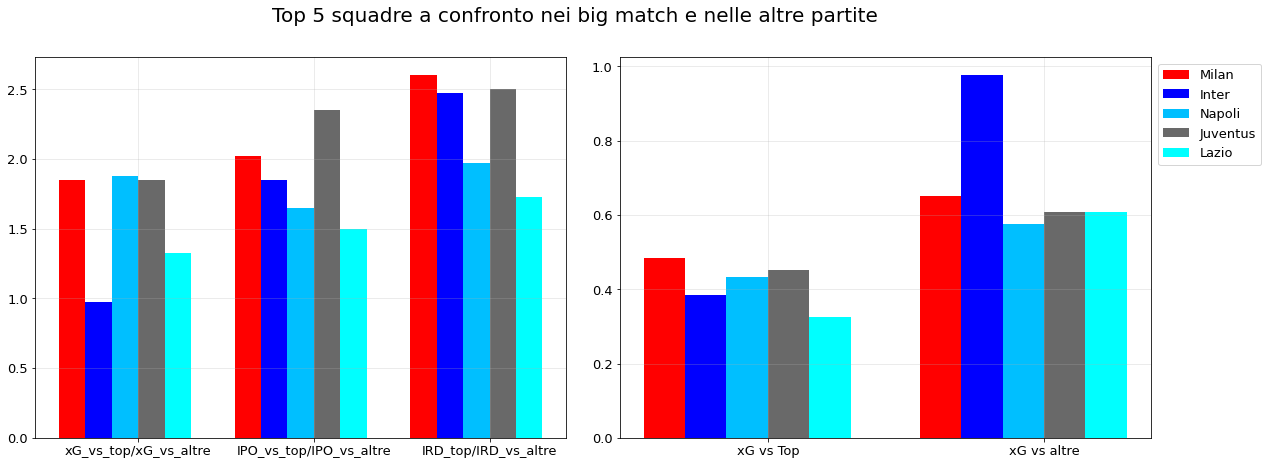

In [56]:
#grafico
#creo due subplots perchè alcune grandezze sono percentuali
#altre sono scalari

f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,7))

plt.subplots_adjust(wspace= 0.1, hspace= 0.35)
X = ['xG_vs_top/xG_vs_altre','IPO_vs_top/IPO_vs_altre', 'IRD_top/IRD_vs_altre']
X1 = ['xG vs Top','xG vs altre']

width = 0.15  # the width of the bars
laz =res.iloc[0][[9,10,11]].values
inter = res.iloc[1][[9,10,11]].values
nap =res.iloc[2][[9,10,11]].values
mil = res.iloc[3][[9,10,11]].values
juv = res.iloc[4][[9,10,11]].values

laz1 =res.iloc[0][[3,4]].values
inter1 = res.iloc[1][[3,4]].values
nap1=res.iloc[2][[3,4]].values
mil1 = res.iloc[3][[3,4]].values
juv1 = res.iloc[4][[3,4]].values

X_axis = np.arange(len(X)) 
mi = ax[0].bar(X_axis - 0.375, mil, width, label = 'Milan', color="red")
inte = ax[0].bar(X_axis - 0.225, inter, width, label = 'Inter', color="blue")
na = ax[0].bar(X_axis - 0.075, nap, width, label = 'Napoli',color="deepskyblue")
ju = ax[0].bar(X_axis + 0.075, juv, width, label = 'Juventus',color="dimgray")
la = ax[0].bar(X_axis + 0.225, laz, width, label = 'Lazio', color ="cyan")

X_axis1 = np.arange(len(X1)) 
mi1 = ax[1].bar(X_axis1 - 0.375, mil1, width, label = 'Milan', color="red")
inte1 = ax[1].bar(X_axis1 - 0.225, inter1, width, label = 'Inter', color="blue")
na1 = ax[1].bar(X_axis1 - 0.075, nap1, width, label = 'Napoli',color="deepskyblue")
ju1 = ax[1].bar(X_axis1 + 0.075, juv1, width, label = 'Juventus',color="dimgray")
la1 = ax[1].bar(X_axis1 + 0.225, laz1, width, label = 'Lazio', color ="cyan")

#ax[1].bar_label(mi, fontsize = 12)
#ax[1].bar_label(inte, fontsize = 12)
#ax[1].bar_label(na, fontsize = 12)
#ax[1].bar_label(ju, fontsize = 12)
#ax[1].bar_label(la, fontsize = 12)

#ax[1].bar_label(mi1, fontsize = 13)
#ax[1].bar_label(inte1, fontsize = 13)
#ax[1].bar_label(na1, fontsize = 13)
#ax[1].bar_label(ju1, fontsize = 13)
#ax[1].bar_label(la1, fontsize = 13)
ax[0].set_yticklabels(np.arange(0,3,0.5),fontsize = 13)

ax[1].set_yticklabels(np.round(np.arange(0,1.2,0.2),1), fontsize = 13)
ax[0].set_xticks(X_axis)
ax[0].set_xticklabels(X,fontsize = 13)
ax[1].set_xticks(X_axis1)
ax[1].set_xticklabels(X1,fontsize = 13)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)
plt.legend(fontsize =13, bbox_to_anchor=(1.22,1))
f.suptitle("Top 5 squadre a confronto nei big match e nelle altre partite", fontsize = 20)
plt.savefig("top5.jpeg")

In [57]:
#tutti i big match
big_match = df_event[df_event.team.isin(squadre_) & df_event.opp_team.isin(squadre_)]

#i big match giocati dall'inter
big_inter = big_match[(big_match.team_id == 127) | (big_match.opp_team_id == 127)]

#tutti gli altri match
flop_match = df_event[df_event.team.isin(squadre_flop + ["Internazionale"]) & df_event.opp_team.isin(squadre_flop + ["Internazionale"])]

#gli altri match giocati dall'Inter
flop_inter = flop_match[(flop_match.team_id == 127) | (flop_match.opp_team_id == 127)]

In [58]:
#nomi colonne
columns=["possesso", "field", "forward", "foul", "ball_rec", "palle_lunghe", "tiri_area", "gol", "tiri_subiti_area", "gol_subiti", "xG_prodotti", "xG_subiti"]

In [61]:
def possesso(df):
  #obiettivo è calcolare il possesso dell'Inter dato un df in input

  #passaggi dell'Inter
  pass_team = len(df[(df.team_id == 127) & (df.type_id == 1)])

  #passaggi avversari
  pass_opp = len(df_event[(df_event.opp_team_id == 127)& (df.type_id == 1)])

  #possesso
  possesso_sq = (pass_team/(pass_team + pass_opp))*100
  return round(possesso_sq,2)

def other(df):
  #obiettivo della funzione è calcolare alcune metriche per l'Inter dato un df

  #passaggi completati
  completed_pass = len(df[((df.team_id == 127) & (df.type_id == 1) & (df.outcome == 1))])

  #forwardness
  forwardness = (len(df[(df.team_id == 127) & (df.type_id ==1) & (df.outcome==1) & (df.x < df.end_x)])/completed_pass)*100

  #palle lunghe
  palle_lunghe = (len(df[(df.team_id == 127) & (df.type_id ==1) & (df.outcome==1) & (df.x < 100/3) & (df.end_x >= 100*2./3)])/completed_pass)*100

  #falli
  foul = (len(df[(df.team_id == 127) & (df.type_id ==4) & (df.outcome==0)]))/(len(df.game_id.unique()))

  #palle recuperate
  ball_rec = (len(df[(df.team_id == 127) & (df.type_id ==49) & (df.x > 2*100/3)]))/(len(df.game_id.unique()))

  #non considero i rigori

  #tiri in area
  tiri_area = len(df[((df.team_id == 127) & (~df.penalty) & (df.x > 83) & (df.y < 78.8) & (df.y > 21.2) &
                          ((df.type_id == 13) | (df.type_id == 14) | (df.type_id == 15) | (df.type_id == 16)))])/(len(df.game_id.unique()))
  #gol                        
  gol = len(df[((df.team_id == 127) & (df.type_id == 16) & (~df.penalty))])/(len(df.game_id.unique()))

  #tiri in area subiti
  tiri_area_subiti = len(df[((df.opp_team_id == 127) & (~df.penalty) & (df.x > 83) & (df.y < 78.8) & (df.y > 21.2) &
                          ((df.type_id == 13) | (df.type_id == 14) | (df.type_id == 15) | (df.type_id == 16)))])/(len(df.game_id.unique()))
  #gol subiti
  gol_subiti = len(df[((df.opp_team_id == 127) & (df.type_id == 16) & (~df.penalty))])/(len(df.game_id.unique()))

  #xG subiti
  xG_subiti = sum(df[(df.opp_team_id == 127) & (~df.penalty)]["xG"].fillna(0))/(len(df.game_id.unique()))

  #xG prodotti
  xG_prodotti = sum(df[(df.team_id == 127) & (~df.penalty)]["xG"].fillna(0))/(len(df.game_id.unique()))
  
  risul = [round(forwardness,2), round(foul,2), round(ball_rec,2), round(palle_lunghe,2), round(tiri_area,2), round(gol,2), round(tiri_area_subiti, 2), round(gol_subiti, 2), round(xG_prodotti, 2), round(xG_subiti, 2)]
  return risul

def field(df):
  #obiettivo è calcolare il field tilt dell'Inter dato un df in input

  #passaggi Inter terzo offensivo
  pass_team = len(df[((df.team_id == 127) & (df.type_id == 1) & (df.end_x >= 100*2./3) & (df.x >= 100*2./3))])

  #passaggi avversari Inter terzo offensivo
  pass_opp = len(df[((df_event.opp_team_id == 127) & (df.type_id == 1) & (df.end_x >= 100*2./3) & (df.x >= 100*2./3) )])

  #field tilt
  field_tilt = (pass_team/(pass_team + pass_opp))*100
  return round(field_tilt,2)

def otherss(df):
  #è identica alla funzione 'other' eccetto per la normalizzazione, lì consideravo un numero intero di partite
  #qua normalizzo per 90 minuti

  #i secondi giocati nel frangente di partita che mi interessa
  sec = []

  #considero le partite che contiene il momento di partita di interesse
  for i in range(len(df.game_id.unique())):

    #faccio la differenza fra i due timestamp che contengono il momento di interesse in quella partita
    #poi trasformo questa differenza in un intero
    sec.append(np.timedelta64(datetime.strptime(df.groupby("game_id").max()["timestamp"].iloc[i], "%Y-%m-%d %H:%M:%S") - datetime.strptime(df.groupby("game_id").min()["timestamp"].iloc[i], "%Y-%m-%d %H:%M:%S"), 'ns').astype('timedelta64[s]').astype(int))

  #tutto come prima eccetto la normalizzazione
  completed_pass = len(df[((df.team_id == 127) & (df.type_id == 1) & (df.outcome == 1))])

  forwardness = (len(df[(df.team_id == 127) & (df.type_id ==1) & (df.outcome==1) & (df.x < df.end_x)])/completed_pass)*100

  palle_lunghe = (len(df[(df.team_id == 127) & (df.type_id ==1) & (df.outcome==1) & (df.x < 100/3) & (df.end_x >= 100*2./3)])/completed_pass)*100

  foul = (len(df[(df.team_id == 127) & (df.type_id ==4) & (df.outcome==0)])) / ((sum(sec)/60)/90)

  ball_rec = (len(df[(df.team_id == 127) & (df.type_id ==49) & (df.x > 2*100/3)]))/((sum(sec)/60)/90)

  tiri_area = len(df[((df.team_id == 127) & (~df.penalty) & (df.x > 83) & (df.y < 78.8) & (df.y > 21.2) &
                          ((df.type_id == 13) | (df.type_id == 14) | (df.type_id == 15) | (df.type_id == 16)))])/((sum(sec)/60)/90)

  gol = len(df[((df.team_id == 127) & (df.type_id == 16) & (~df.penalty))])/((sum(sec)/60)/90)

  tiri_area_subiti = len(df[((df.opp_team_id == 127) & (~df.penalty) & (df.x > 83) & (df.y < 78.8) & (df.y > 21.2) &
                          ((df.type_id == 13) | (df.type_id == 14) | (df.type_id == 15) | (df.type_id == 16)))])/((sum(sec)/60)/90)

  gol_subiti = len(df[((df.opp_team_id == 127) & (df.type_id == 16) & (~df.penalty))])/((sum(sec)/60)/90)

  xG_subiti = sum(df[(df.opp_team_id == 127) & (~df.penalty)]["xG"].fillna(0))/((sum(sec)/60)/90)

  xG_prodotti = sum(df[(df.team_id == 127) & (~df.penalty)]["xG"].fillna(0))/((sum(sec)/60)/90)
  
  risul = [round(forwardness,2), round(foul,2), round(ball_rec,2), round(palle_lunghe,2), round(tiri_area,2), round(gol,2), round(tiri_area_subiti, 2), round(gol_subiti, 2), round(xG_prodotti, 2), round(xG_subiti, 2)]
  return risul

In [62]:
#estraggo le seguenti grandezze usando la funzione 'others'
forward, foul, ball_rec, palle_lunghe, tiri_nv_area, gol, tiri_nv_subiti_area, gol_subiti, xG_prod, xG_sub = other(big_inter)
forward1, foul1, ball_rec1, palle_lunghe1, tiri_nv_area1, gol1, tiri_nv_subiti_area1, gol_subiti1, xG_prod1, xG_sub1 = other(flop_inter)

#applico inoltre la funzione 'possesso' e 'field' e creo una lista
lista = [possesso(big_inter), field(big_inter), forward, foul, ball_rec, palle_lunghe, tiri_nv_area, gol, tiri_nv_subiti_area, gol_subiti, xG_prod, xG_sub]
lista1 = [possesso(flop_inter), field(flop_inter), forward1, foul1, ball_rec1, palle_lunghe1, tiri_nv_area1, gol1, tiri_nv_subiti_area1, gol_subiti1, xG_prod1, xG_sub1]

#da lista a df
df_res = pd.DataFrame(list(zip(lista, lista1)), columns = ["big match", "others"])
df_res["columns"] = columns
df_res = df_res.set_index("columns")
df_res

,big match,others
columns,,
possesso,49.76,58.52
field,50.85,64.74
forward,57.27,57.91
foul,14.50,11.67
ball_rec,1.38,2.63
palle_lunghe,0.33,0.28
tiri_area,6.88,13.93
gol,1.00,2.30
tiri_subiti_area,8.25,6.00


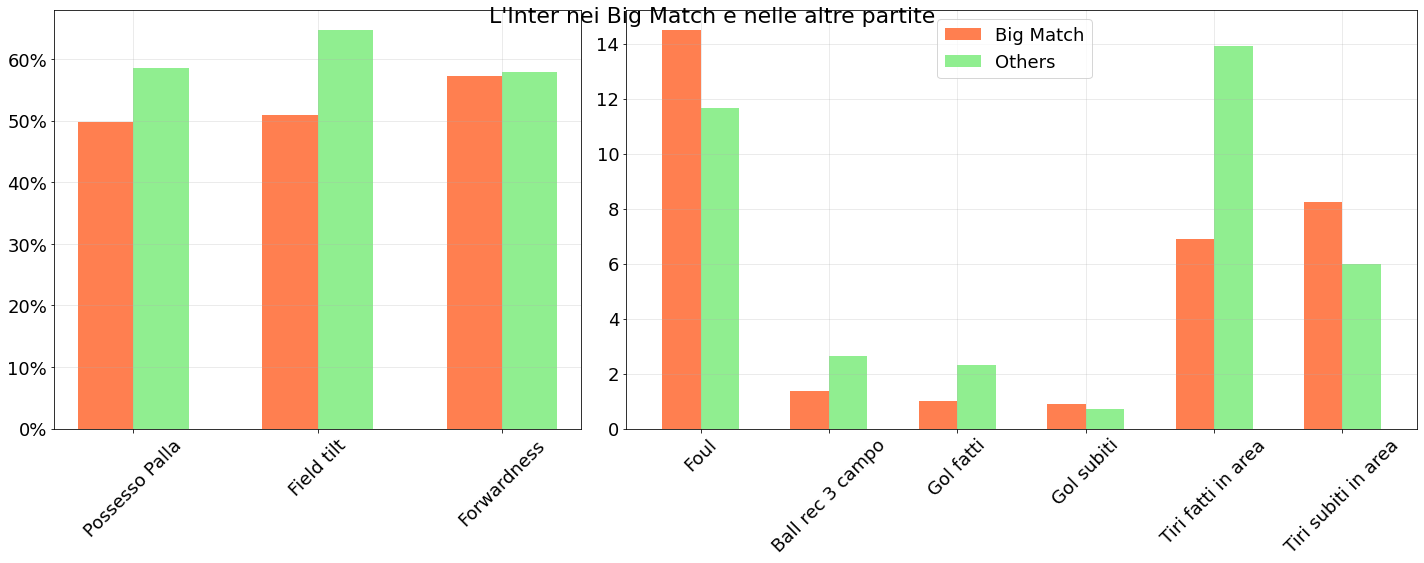

In [63]:
#grafico
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8), gridspec_kw={'width_ratios': [1,1.5]})

plt.subplots_adjust(wspace= 0.1, hspace= 0.35)


X = ['Possesso Palla','Field tilt', "Forwardness"]
X1 = ["Foul", "Ball rec 3 campo", "Gol fatti", "Gol subiti", "Tiri fatti in area",  "Tiri subiti in area"]
width = 0.3  # the width of the bars

big =df_res["big match"].iloc[[0,1,2]].values
other =df_res["others"].iloc[[0,1,2]].values
big1 =df_res["big match"].iloc[[3,4,7,9,6,8]].values
other1 =df_res["others"].iloc[[3,4,7,9,6,8]].values

X_axis = np.arange(len(X)) 
X_axis1 = np.arange(len(X1)) 
bigs= ax[0].bar(X_axis - 0.15, big, width, label = 'Big Match', color="coral")
others = ax[0].bar(X_axis + 0.15, other, width, label = 'Others', color="lightgreen")

bigs1 = ax[1].bar(X_axis1 - 0.15, big1, width, label = 'Big Match', color="coral")
others1 = ax[1].bar(X_axis1 + 0.15, other1, width, label = 'Others', color="lightgreen")


#ax[0].bar_label(bigs, fontsize = 14)
#ax[0].bar_label(others, fontsize = 14)
#ax[1].bar_label(bigs1, fontsize = 14)
#ax[1].bar_label(others1, fontsize = 14)

ytic = []
for i in np.arange(0,70,10):
  ytic.append(f'{i}%')

ax[0].set_xticks(X_axis)
ax[0].set_xticklabels(X, fontsize = 18, rotation = 45)
ax[1].set_xticks(X_axis1)
ax[1].set_xticklabels(X1, fontsize = 18, rotation = 45)
ax[0].set_yticks(np.arange(0,70,10))
ax[0].set_yticklabels(ytic, fontsize = 18)
ax[1].set_yticks(np.arange(0,16,2))
ax[1].set_yticklabels(np.arange(0,16,2), fontsize = 18)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)
plt.legend(fontsize =18, bbox_to_anchor=(0.6,1))
f.suptitle("L'Inter nei Big Match e nelle altre partite", fontsize = 22)
plt.tight_layout()
plt.savefig("Intertop5.jpeg")

### Situazione di Punteggio

In [64]:
'''
Le successive otto funzioni sono necessarie per trovare i momenti della partita in cui due squadre 
stanno pareggiando, oppure quando una è in vantaggio, e se di uno o più gol, o quando è in svantaggio,
e se di uno o più gol. Sono otto perchè la partita con più gol in serie a ha avuto 8 gol. 
Ogni funzione prende in esame l'ultimo gol fatto (es. primogol prende in funzione il primo gol). 
La lunghezza della funzione dipende solo dalle possibili situazioni di punteggio in cui possono essere
le squadre(es. in primogol le squadre possono essere solo 0-0 e il risultato può diventare solo 1-0, 0-1, mentre invece ad esempio in gol7
le situazioni possono essere molte di più).
(Avrei potuto svolgere tutto questo anche usando il df_event, forse era più semplice.)

input:
team: è la squadra presa in considerazione
momento_succ: è il gol successivo o la fine della partita
df_ipo_gol: è una df definito fuori dalla funzione, globale, in cui si filtra il df_ipo e si prendono solo 
gli eventi gol

output:
v: di quanto la squadra è in vantaggio (1 se vince di un gol, 2 di due gol...), se 0 pareggia, se negativo sta perdendo
(-1 sta perdendo di un gol, -2 di due gol...)

ho commentato solo le prime due, le successive sono analoghe, solo che con molte più situazioni. 
'''

def primogol(momento_succ, team):

  #fino al primo gol le squadre pareggiavano
  par.append(df_ipo_gol.periodMinute.iloc[0] * 60 + df_ipo_gol.periodSecond.iloc[0])

  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[0] == team:
    
    #il team rimane in vantaggio rimane in vantaggio fino al prossimo evento (gol o fine partita)
    vant.append(momento_succ - (df_ipo_gol.periodMinute.iloc[0] * 60 + df_ipo_gol.periodSecond.iloc[0]))

    #aggiorno la situazione di punteggio
    v=1
  else:

    #il team rimane in svantaggio rimane in vantaggio fino al prossimo evento (gol o fine partita)
    svan.append(momento_succ - (df_ipo_gol.periodMinute.iloc[0] * 60 + df_ipo_gol.periodSecond.iloc[0]))

    #aggiorno la situazione di punteggio
    v=-1
  return v

def gol2(momento_succ, v , team):

  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[1] == team:

    #stava 1-0
    if v==1:

      #va sul 2-0
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1]))
      v=2

    #erano 0-1
    else:
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1]))

      #vanno 1-1
      v=0
  else:

    #stava 1-0
    if v==1:

      #vanno 1-1
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1]))
      v=0

    else:
      #va sullo 0-2
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1]))
      v=-2
  return v


def gol3(momento_succ, v, team):
  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[2] == team:
    if v==2:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2]))
      v = 3
    elif v==0:
      vant.append(momento_succ - (df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2]))
      v=1
    else:
      svan.append(momento_succ - (df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2]))
      v=-1
  else:
    if v==2:
      vant.append(momento_succ - (df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2]))
      v=1
    elif v==0:
      svan.append(momento_succ - (df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2]))
      v=-1
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2])) 
      v=-3
  return v

def gol4(momento_succ, v, team):

  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[3] == team:
    if v==3:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=4
    elif v==1:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=2
    elif v==-1:
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=0
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=-2       
  else:
    if v==3:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=2
    elif v==1:
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=0
    elif v==-1:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=-2
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3]))
      v=-4     
  return v

def gol5(momento_succ, v, team):

  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[4] == team:
    if v==4:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=5
    elif v==2:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=3
    elif v==0:
      vant.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=1
    elif v==-2:
      svan.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=-1
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=-3       
  else:
    if v==4:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=3
    elif v==2:
      vant.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=1
    elif v==0:
      svan.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=-1
    elif v==-2:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=-3
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4]))
      v=-5   
  return v

def gol6(momento_succ, v, team):

  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[5] == team:
    if v==5:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=6
    elif v==3:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=4
    elif v==1:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=2
    elif v==-1:
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=0
    elif v==-3:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=-2
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=-4      
  else:
    if v==5:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=4
    elif v==3:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=2
    elif v==1:
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=0
    elif v==-1:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=-2
    elif v==-3:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=-4
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5]))
      v=-6  
  return v

def gol7(momento_succ, v, team):

  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[6] == team:
    if v==6:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=7
    elif v==4:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=5
    elif v==2:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=3
    elif v==0:
      vant.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=1
    elif v==-2:
      svan.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=-1
    elif v==-4:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=-3
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=-5      
  else:
    if v==6:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=5
    elif v==4:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=3
    elif v==2:
      vant.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=1
    elif v==0:
      svan.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=-1
    elif v==-2:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=-3
    elif v==-4:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=-5
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6]))
      v=-7 
  return v

def gol8(momento_succ, v, team):

  #ha segnato la squadra in esame o la rivale?
  if df_ipo_gol.team.iloc[7] == team:
    if v==7:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=8
    elif v==5:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=6
    elif v==3:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=4
    elif v==1:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=2
    elif v==-1:
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=0
    elif v==-3:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=-2
    elif v==-5:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=-4
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=-6      
  else:
    if v==7:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=6
    elif v==5:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=4
    elif v==3:
      vant2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=2
    elif v==1:
      par.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=0
    elif v==-1:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=-2
    elif v==-3:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=-4
    elif v==-5:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=-6
    else:
      svan2.append(momento_succ - (df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7]))
      v=-8 
  return v

In [65]:
#copia del df_ipo, così da non modificare l'originale
#modifico la colonna minuti in modo tale da averli fino a 90
df_ipo2 = df_ipo.copy()
for i in range(len(df_ipo2)):

  #se l'evento accade nel secondo tempo
  if df_ipo2.period.iloc[i] == 2:

    #minuto totale della partita (non sto considerando i minuti di recupero del primo tempo)
    df_ipo2.periodMinute.iloc[i] = df_ipo2.periodMinute.iloc[i] + 45

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [66]:
min = []

#per ogni team
for team in df_ipo.team.unique():
  match = []


  #per ogni match giocato nel campionato
  for i in df_ipo.match_name.unique():

    #se il team sta giocando quel match 
    if i.find(team) != -1:
      match.append(i)

  #liste che contengono quanti secondi quella squadra pareggia, vince di un gol, vince di due  o più gol,
  #perde di un gol, perde di due o più gol    
  par = []
  vant = []
  svan = []
  vant2 = []
  svan2=[]

  #per ogni match giocato dal team
  for i in range(len(match)):

    #prendo solo gli eventi gol 
    df_ipo_gol = df_ipo2[(df_ipo2["oiTypeName"] == "goal") & (df_ipo2.match_name == match[i])][["match_name", "team", "period", "periodMinute", "periodSecond", "OffensiveIndex"]].reset_index(drop=True)

    #salvo l'ultimo evento di quel match  
    ultimo_evento = df_ipo2[(df_ipo2.match_name == match[i])]["periodMinute"].max()

    #se è avvenuto prima del 90', assumo arbitrariamente che la partita sia finita al 95'
    #sennò assumo che la partita sia finita con quell'evento. 
    #questa approssimazione non è precisa al secondo! 

    if ultimo_evento < 90:
      ultimo_evento = 95

    #se la partita è finita 0-0 assumo arbitrariamente che la partita è finita al 95' 
    if len(df_ipo_gol) == 0:
      par.append(95*60)

    elif len(df_ipo_gol) == 1:

        #questo se è messo se il gol, coincide con l'ultimo evento della partita. Se sì,
        #anche avendo segnato quella squadra non passerà tempo in vantaggio/svantaggio. 
        #questo se è messo sempre per l'ultimo gol. 
        if df_ipo_gol.periodMinute.iloc[0] <= ultimo_evento:
          primogol(ultimo_evento*60, team)

    elif len(df_ipo_gol) == 2:
      v = primogol(df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1], team)
      if df_ipo_gol.periodMinute.iloc[1] <= ultimo_evento:
        gol2(ultimo_evento*60, v, team)

    elif len(df_ipo_gol) == 3:
      v = primogol(df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1], team)
      v = gol2(df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2], v, team)
      if df_ipo_gol.periodMinute.iloc[2] <= ultimo_evento:
        v = gol3(ultimo_evento*60, v, team)
        
    elif len(df_ipo_gol) == 4:
      v = primogol(df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1], team)
      v = gol2(df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2], v, team)
      v = gol3(df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3], v, team)
      if df_ipo_gol.periodMinute.iloc[3] <= ultimo_evento:
        v = gol4(ultimo_evento*60, v, team)

    elif len(df_ipo_gol) == 5:
      v = primogol(df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1], team)
      v = gol2(df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2], v, team)
      v = gol3(df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3], v, team)
      v = gol4(df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4], v, team)
      if df_ipo_gol.periodMinute.iloc[4] <= ultimo_evento:
        v = gol5(ultimo_evento*60, v, team)

    elif len(df_ipo_gol) == 6:
      v = primogol(df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1], team)
      v = gol2(df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2], v, team)
      v = gol3(df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3], v, team)
      v = gol4(df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4], v, team)
      v = gol5(df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5], v, team)
      if df_ipo_gol.periodMinute.iloc[5] <= ultimo_evento:
        v = gol6(ultimo_evento*60, v, team)

    elif len(df_ipo_gol) == 7:
      v = primogol(df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1], team)
      v = gol2(df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2], v, team)
      v = gol3(df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3], v, team)
      v = gol4(df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4], v, team)
      v = gol5(df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5], v, team)
      v = gol6(df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6], v, team)
      if df_ipo_gol.periodMinute.iloc[6] <= ultimo_evento:
        v = gol7(ultimo_evento*60, v, team)

    else:
      v = primogol(df_ipo_gol.periodMinute.iloc[1] * 60 + df_ipo_gol.periodSecond.iloc[1], team)
      v = gol2(df_ipo_gol.periodMinute.iloc[2] * 60 + df_ipo_gol.periodSecond.iloc[2], v, team)
      v = gol3(df_ipo_gol.periodMinute.iloc[3] * 60 + df_ipo_gol.periodSecond.iloc[3], v, team)
      v = gol4(df_ipo_gol.periodMinute.iloc[4] * 60 + df_ipo_gol.periodSecond.iloc[4], v, team)
      v = gol5(df_ipo_gol.periodMinute.iloc[5] * 60 + df_ipo_gol.periodSecond.iloc[5], v, team)
      v = gol6(df_ipo_gol.periodMinute.iloc[6] * 60 + df_ipo_gol.periodSecond.iloc[6], v, team)
      v = gol7(df_ipo_gol.periodMinute.iloc[7] * 60 + df_ipo_gol.periodSecond.iloc[7], v, team)
      if df_ipo_gol.periodMinute.iloc[7] <= ultimo_evento:
        v = gol8(ultimo_evento*60, v, team)        

  #minuti totali giocati da quella squadra
  tot = (sum(par)/60 + sum(svan)/60 + sum(svan2)/60 + sum(vant)/60 + sum(vant2)/60)
  
  #df in cui ogni colonna è la percentuale del tempo passata da quella squadra in una certa condizione di punteggio 
  min.append([(round(sum(svan2)/60)/tot)*100, (round(sum(svan)/60)/tot)*100, (round(sum(par)/60)/tot)*100, (round(sum(vant)/60)/tot)*100, (round(sum(vant2)/60)/tot)*100, team])
min = pd.DataFrame(min, columns = ["Svantaggio >= -2", "Svantaggio -1", "Parità", "Vantaggio +1", "Vantaggio >= +2", "Squadra"])

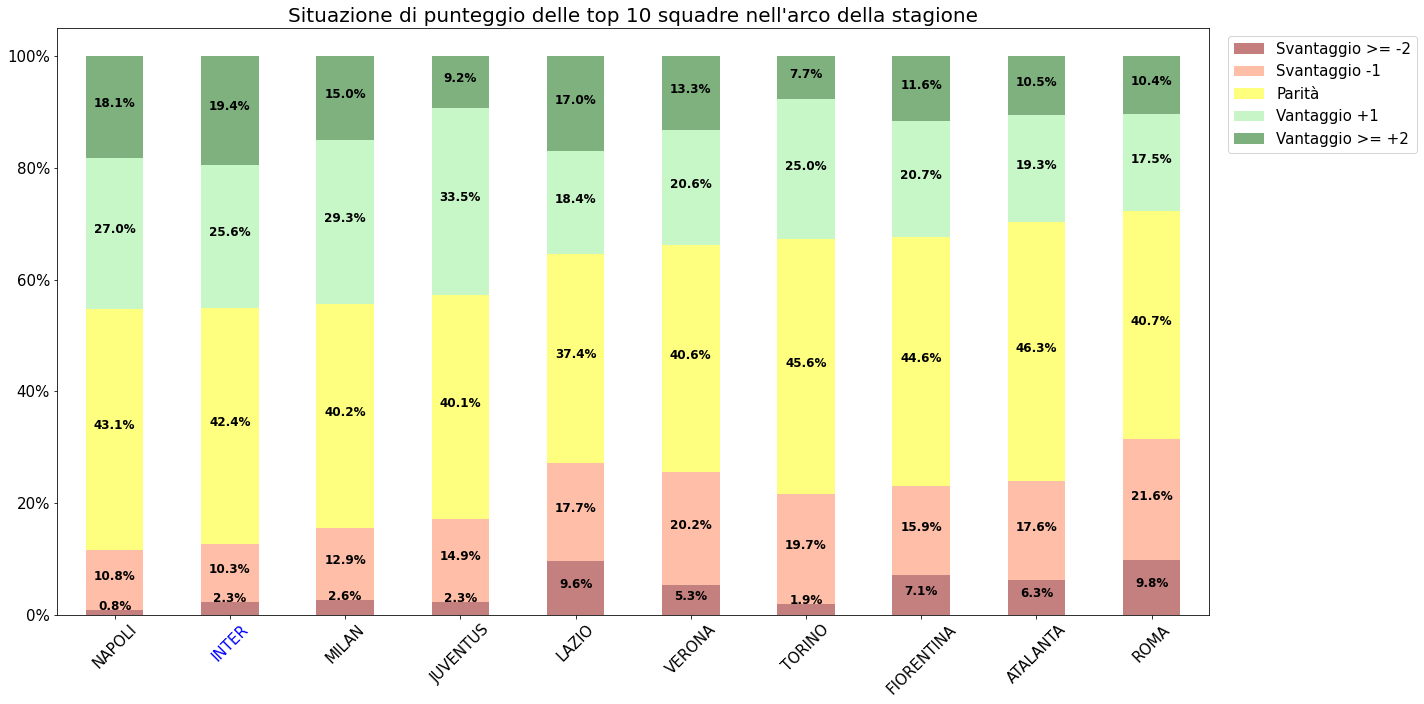

In [67]:
#prime dieci in classifica
squadre_cap = ['NAPOLI', 'FIORENTINA','INTER', 'LAZIO', 'ATALANTA','MILAN', "TORINO", 'JUVENTUS', 'ROMA', "VERONA"]

#seleziono solo le prime dieci
prime_dieci = min[min["Squadra"].isin(squadre_cap)]

#ordino in base alle squadre che hanno passato più tempo in vantaggio
prime_dieci = prime_dieci.loc[prime_dieci[["Vantaggio +1", "Vantaggio >= +2"]].sum(axis=1).sort_values(ascending=False).index]

#barplot orizzontale
prime_dieci.plot(kind="bar", stacked = True, color = ["darkred","coral","yellow","lightgreen","darkgreen"], figsize = (20,10), alpha = 0.5)
plt.xticks(np.arange(0,10,1),prime_dieci.Squadra, rotation=45, fontsize=15)

#aggiungere '%' agli yticks
ytic = []
for i in np.arange(0,120,20):
  ytic.append(f'{i}%')

for i in range(len(prime_dieci)):

  #somma cumulativa delle percentuali
  perc = np.cumsum(prime_dieci.iloc[i, 0:5])

  #scrivo le percentuali nel grafico
  for j in range(0,5):
    if j != 0:
      plt.annotate("{:.1f}%".format(prime_dieci.iloc[i, j]), xy =([i, (perc[j]- perc[j-1])/2 + perc[j-1]]), weight = "bold",ha='center', fontsize = 12)
    elif (j == 0) & (perc[j] < 5):
      plt.annotate("{:.1f}%".format(prime_dieci.iloc[i, j]), xy =([i, (perc[j])]), weight = "bold",ha='center', fontsize = 12) 
    else:
      plt.annotate("{:.1f}%".format(prime_dieci.iloc[i, j]), xy =([i, (perc[j]/2)]), weight = "bold",ha='center', fontsize = 12)

#legenda    
plt.legend(bbox_to_anchor = (1.01,1), fontsize=15)
#titolo
plt.title("Situazione di punteggio delle top 10 squadre nell'arco della stagione", fontsize=20)
#ytick
plt.yticks(np.arange(0,120,20), ytic, fontsize=15)
#coloro xtick dell'inter di blue  
plt.gca().get_xticklabels()[1].set_color("blue")
plt.tight_layout() 
#salvo figura
plt.savefig("Minutaggio.jpeg")     

#plt.show()

In [68]:
#partite in cui l'inter ha sbloccato per prima il risultato
vant_1_game = df_event[((df_event.home_team_id == 127) & (df_event.home_score ==  1) & (df_event.away_score == 0)) | ((df_event.away_team_id == 127) & (df_event.away_score == 1) & (df_event.home_score == 0))][["game_id","home_team","away_team"]].drop_duplicates()
vant_1 = df_event[((df_event.home_team_id == 127) & (df_event.home_score ==  1) & (df_event.away_score == 0)) | ((df_event.away_team_id == 127) & (df_event.away_score == 1) & (df_event.home_score == 0))]

In [69]:
#partite in cui l'avversario dell'inter ha sbloccato per prima il risultato
svan_1_game = df_event[((df_event.home_team_id == 127) & (df_event.home_score ==  0) & (df_event.away_score == 1)) | ((df_event.away_team_id == 127) & (df_event.away_score == 0) & (df_event.home_score == 1))][["game_id","home_team","away_team"]].drop_duplicates()
svan_1 = df_event[((df_event.home_team_id == 127) & (df_event.home_score ==  0) & (df_event.away_score == 1)) | ((df_event.away_team_id == 127) & (df_event.away_score == 0) & (df_event.home_score == 1))]

In [70]:
#inizializzazione, conto le partite in cui l'inter, l'avversaria o nessuno ha segnato il secondo gol
#dopo che l'inter ha sbloccato il match
esit = []
inter = 0
altre = 0 
finita = 0
inter_segna = []
altre_segna = []

#per ogni partita in cui l'inter ha sbloccato il risultato
for i in vant_1_game.game_id:

  #se ci sono stati almeno due gol nella partita (non considerando autogol)
  if len(df_event[(df_event.game_id == i) & (df_event.type_id ==16) & (df_event.owngoal == 0)]["team_id"]) > 1:

    #se l'inter ha segnato il secondo gol
    if df_event[(df_event.game_id == i) & (df_event.type_id ==16)].sort_values(by="timestamp")["team_id"].iloc[1] == 127:
      inter_segna.append(i)
      inter += 1
    #l'avversaria ha segnato il secondo gol
    else:
      altre += 1
      altre_segna.append(i)

  else:
    #se il secondo gol è stato un autogol
    if len(df_event[(df_event.game_id == i) & (df_event.type_id ==16) & (df_event.owngoal == 1)]) == 1:

      #se l'inter ha segnato l'autogol
      if df_event[(df_event.game_id == i) & (df_event.type_id ==16)].sort_values(by="timestamp")["team_id"].iloc[1] == 127:
        altre +=1
        altre_segna.append(i)
        
      #se l'avversaria ha segnato l'autogol
      else:
        inter_segna.append(i)
        inter += 1
    #se nessuno ha segnato il secondo gol, l'inter vince
    else:
      finita += 1
      inter_segna.append(i)
  #segno quali di queste partite l'inter ha vinto, perso o pareggiato
  for j in range(len(stagione_inter)):
    if i == stagione_inter.game_id.iloc[j]:
      esit.append(stagione_inter.Esito.iloc[j])

In [71]:
print("L'inter quando sblocca la partita segna il secondo gol in", str(inter), "partite")
print("L'inter quando sblocca la partita mantiene il risultato sull'1-0 in", str(finita), "partite")
print("L'inter quando sblocca la partita subisce il secondo gol in", str(altre), "partite")

L'inter quando sblocca la partita segna il secondo gol in 16 partite
L'inter quando sblocca la partita mantiene il risultato sull'1-0 in 2 partite
L'inter quando sblocca la partita subisce il secondo gol in 8 partite


In [72]:
#inizializzazione, conto le partite in cui l'inter, l'avversaria o nessuno ha segnato il secondo gol
#dopo che l'avversario dell'inter ha sbloccato il match
esit1 = []
inter1 = 0
altre1 = 0 
finita1 = 0
finita = 0
inter_segna1 = []
altre_segna1 = []

#per ogni partita in cui l'avversario dell'inter ha sbloccato il risultato
for i in svan_1_game.game_id:

  #se ci sono stati almeno due gol nella partita (non considerando autogol)
  if len(df_event[(df_event.game_id == i) & (df_event.type_id ==16) & (df_event.owngoal == 0)]["team_id"]) > 1:

    #se l'inter ha segnato il secondo gol
    if df_event[(df_event.game_id == i) & (df_event.type_id ==16)].sort_values(by="timestamp")["team_id"].iloc[1] == 127:
      inter1 += 1
      inter_segna1.append(i)

    #l'avversaria ha segnato il secondo gol
    else:
      altre1 += 1
      altre_segna1.append(i)

  else:
    #se il secondo gol è stato un autogol
    if len(df_event[(df_event.game_id == i) & (df_event.type_id ==16) & (df_event.owngoal == 1)]) == 1:
      #se l'inter ha segnato l'autogol
      if df_event[(df_event.game_id == i) & (df_event.type_id ==16)].sort_values(by="timestamp")["team_id"].iloc[1] == 127:      
        altre1 +=1
        altre_segna1.append(i)
      #se l'avversaria ha segnato l'autogol
      else:
        inter_segna.append(i)
        inter += 1

    #se nessuno ha segnato il secondo gol, l'inter perde
    else:
      finita1 += 1
      altre_segna1.append(i)

  #segno quali di queste partite l'inter ha vinto, perso o pareggiato
  for j in range(len(stagione_inter)):
    if i == stagione_inter.game_id.iloc[j]:
      esit1.append(stagione_inter.Esito.iloc[j])

In [73]:
inter_segna1 = svan_1[svan_1.game_id.isin(inter_segna1)]
altre_segna1 = svan_1[svan_1.game_id.isin(altre_segna1)]

In [74]:
print("Quando l'avversaria dell'Inter sblocca la partita, l'Inter segna il secondo gol in", str(inter1), "partite")
print("Quando l'avversaria dell'Inter sblocca la partita, l'Inter rimane sullo 0-1 in", str(finita1), "partite")
print("Quando l'avversaria dell'Inter sblocca la partita, l'Inter subisce il secondo gol in", str(altre1), "partite")

Quando l'avversaria dell'Inter sblocca la partita, l'Inter segna il secondo gol in 8 partite
Quando l'avversaria dell'Inter sblocca la partita, l'Inter rimane sullo 0-1 in 0 partite
Quando l'avversaria dell'Inter sblocca la partita, l'Inter subisce il secondo gol in 2 partite


In [75]:
print("Quando l'Inter segna per prima porta a casa almeno un punto nel", str( round((esit.count("W") + esit.count("D"))/len(esit)*100,1) )+"% dei casi")

Quando l'Inter segna per prima porta a casa almeno un punto nel 88.5% dei casi


In [76]:
print("Quando l'Inter segna per prima vince nel", str(round((esit.count("W"))/len(esit)*100,1))+"% dei casi")

Quando l'Inter segna per prima vince nel 73.1% dei casi


In [77]:
inter_segna2 = vant_1[vant_1.game_id.isin(inter_segna)]
altre_segna2 = vant_1[vant_1.game_id.isin(altre_segna)]

In [78]:
forward, foul, ball_rec, palle_lunghe, tiri_nv_area, gol, tiri_nv_subiti_area, gol_subiti, xG_prod, xG_sub = otherss(inter_segna2)
forward1, foul1, ball_rec1, palle_lunghe1, tiri_nv_area1, gol11, tiri_nv_subiti_area1, gol_subiti1, xG_prod1, xG_sub1 = otherss(altre_segna2)

lista = [possesso(inter_segna2), field(inter_segna2), forward, foul, ball_rec, palle_lunghe, tiri_nv_area, gol, tiri_nv_subiti_area, gol_subiti, xG_prod, xG_sub]
lista1 = [possesso(altre_segna2), field(altre_segna2), forward1, foul1, ball_rec1, palle_lunghe1, tiri_nv_area1, gol11, tiri_nv_subiti_area1, gol_subiti1, xG_prod1, xG_sub1]
df_res1 = pd.DataFrame(list(zip(lista, lista1)), columns = ["Inter segna", "Avversaria segna"])
df_res1["columns"] = columns
df_res1 = df_res1.set_index("columns")
df_res1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:80: FutureWarning: Dropping invalid columns in DataFrameGroupBy.min is deprecated. In a future version, a TypeError will be raised. Before calling .min, select only columns which should be valid for the function.


,Inter segna,Avversaria segna
columns,,
possesso,57.38,46.93
field,62.72,49.23
forward,58.38,56.80
foul,6.15,10.07
ball_rec,2.05,0.86
palle_lunghe,0.17,0.38
tiri_area,8.76,5.46
gol,1.93,1.73
tiri_subiti_area,2.62,4.89


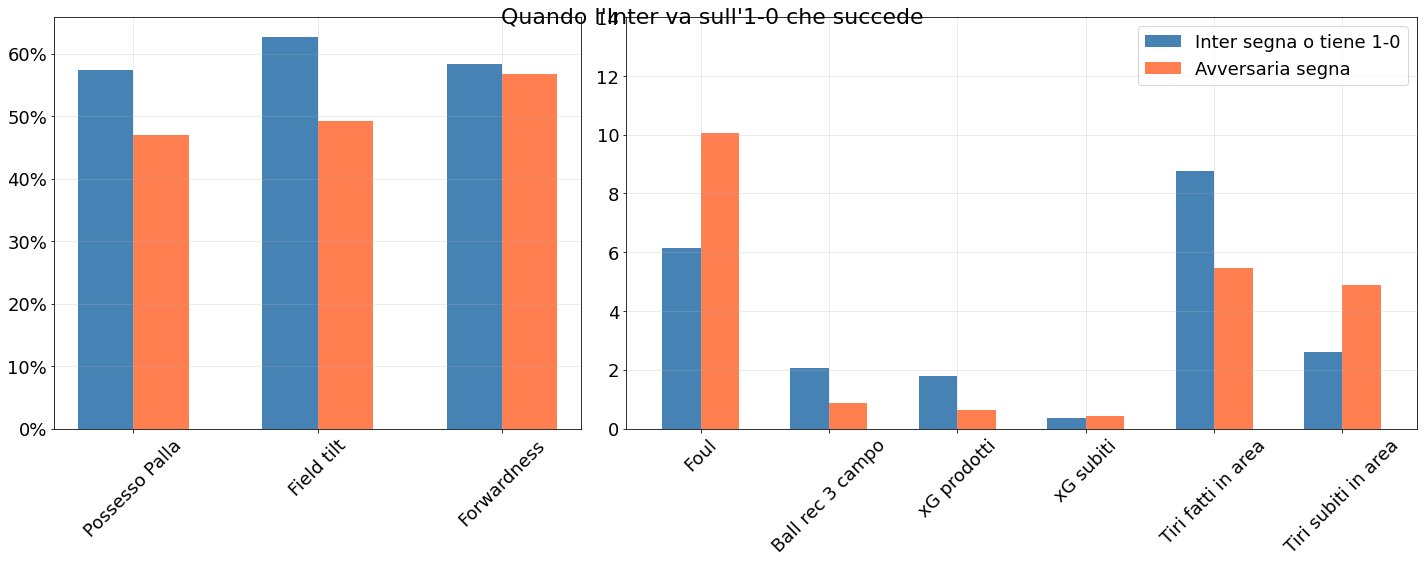

In [79]:
#grafico
f, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8), gridspec_kw={'width_ratios': [1,1.5]})

plt.subplots_adjust(wspace= 0.1, hspace= 0.35)


X = ['Possesso Palla','Field tilt', "Forwardness"]
X1 = ["Foul", "Ball rec 3 campo", "xG prodotti", "xG subiti", "Tiri fatti in area",  "Tiri subiti in area"]
width = 0.3  # the width of the bars

big =df_res1["Inter segna"].iloc[[0,1,2]].values
other =df_res1["Avversaria segna"].iloc[[0,1,2]].values
big1 =df_res1["Inter segna"].iloc[[3,4,10,11,6,8]].values
other1 =df_res1["Avversaria segna"].iloc[[3,4,10,11,6,8]].values

X_axis = np.arange(len(X)) 
X_axis1 = np.arange(len(X1)) 
bigs= ax[0].bar(X_axis - 0.15, big, width, label = 'Inter segna o tiene 1-0', color="steelblue")
others = ax[0].bar(X_axis + 0.15, other, width, label = 'Avversaria segna', color="coral")

bigs1 = ax[1].bar(X_axis1 - 0.15, big1, width, label = 'Inter segna o tiene 1-0', color="steelblue")
others1 = ax[1].bar(X_axis1 + 0.15, other1, width, label = 'Avversaria segna', color="coral")


#ax[0].bar_label(bigs, fontsize = 14)
#ax[0].bar_label(others, fontsize = 14)
#ax[1].bar_label(bigs1, fontsize = 14)
#ax[1].bar_label(others1, fontsize = 14)

ytic = []
for i in np.arange(0,70,10):
  ytic.append(f'{i}%')

ax[0].set_xticks(X_axis)
ax[0].set_xticklabels(X, fontsize = 18, rotation = 45)
ax[1].set_xticks(X_axis1)
ax[1].set_xticklabels(X1, fontsize = 18, rotation = 45)
ax[0].set_yticks(np.arange(0,70,10))
ax[0].set_yticklabels(ytic, fontsize = 18)
ax[1].set_yticks(np.arange(0,16,2))
ax[1].set_yticklabels(np.arange(0,16,2), fontsize = 18)
ax[0].grid(alpha=0.3)
ax[1].grid(alpha=0.3)
plt.legend(fontsize =18, bbox_to_anchor=(1,1))
f.suptitle("Quando l'Inter va sull'1-0 che succede", fontsize = 22)
plt.tight_layout()
plt.savefig("Intervant.jpeg")

### Minutaggio

In [80]:
min = []
a = pd.DataFrame()

#per ogni squadra
for i in squadre.team_id:

  #raggruppo per giocatore, sommo i minuti giocati da ognuno
  minss = df_part[(df_part.team_id == i)].groupby("opta_id").sum()[["mins_played"]]

  #faccio questo merge per avere il nome corrispondente all'opta_id
  gioc_inter = df_part[df_part.team_id == i][["opta_id", "Giocatore", "Età", "soccRole", "Team"]].drop_duplicates()
  mins = minss.merge(gioc_inter, on="opta_id")

  #filtro i giocatori con più di 300 minuti 
  mins = mins[mins.mins_played > 300]

  #concateno i giocatori delle diverse squadre
  a = pd.concat([a,mins])

In [81]:
#vedo per le top5 squadre quanti sono i giocatori con più di 900 e 2000 minuti
for i in ["Inter Milan", "Milan", "Juventus", "Napoli", "Lazio"]:
  print(len(a[(a.mins_played > 2000) & (a.Team == i)]))
  print(len(a[(a.mins_played > 900) & (a.Team == i)]))
  print("##########")

10
14
##########
6
16
##########
7
18
##########
7
15
##########
9
15
##########


In [82]:
#età di picco per i diversi ruoli
winger = 26
fb = 27
midfielder = 27
cb = 28 
striker = 28

#inizializzazione
a["peak"] = 0

#per ogni ruolo, se l'età dei giocatori con più di 300 minuti è maggiore 
#o minore di al più un anno dall'età di picco la variabile peak sarà uguale
#a 2, se invece è inferiore a questo range peak varrà 1, se più grande varrà 3

for i in range(len(a)):
  if a.soccRole.iloc[i] == "FW":
    if a.Età.iloc[i] < striker - 1:
      a.peak.iloc[i] = 1
    elif a.Età.iloc[i] > striker + 1:
      a.peak.iloc[i] = 3
    else:
      a.peak.iloc[i] = 2
  if a.soccRole.iloc[i] == "FB":
    if a.Età.iloc[i] < fb - 1:
      a.peak.iloc[i] = 1
    elif a.Età.iloc[i] > fb + 1:
      a.peak.iloc[i]= 3
    else:
      a.peak.iloc[i] = 2
  if a.soccRole.iloc[i] == "CB":
    if a.Età.iloc[i] < cb - 1:
      a.peak.iloc[i] = 1
    elif a.Età.iloc[i] > cb + 1:
      a.peak.iloc[i] = 3
    else:
      a.peak.iloc[i] = 2
  if a.soccRole.iloc[i] == "WAM":
    if a.Età.iloc[i] < winger - 1:
      a.peak.iloc[i] = 1
    elif a.Età.iloc[i] > winger + 1:
      a.peak.iloc[i] = 3
    else:
      a.peak.iloc[i] = 2
  if ((a.soccRole.iloc[i] == "CM") | (a.soccRole.iloc[i] == "CAM") | (a.soccRole.iloc[i] == "DMC")):
    if a.Età.iloc[i] < winger - 1:
      a.peak.iloc[i] = 1
    elif a.Età.iloc[i] > winger + 1:
      a.peak.iloc[i] = 3
    else:
      a.peak.iloc[i] = 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [83]:
#conto per ogni squadra, quanti giocatori sono sotto, sopra o nella fascia del picco d'età
bb = a.groupby(["Team", "peak"]).count().reset_index()

#rinomino "Inter Milan" in "Internazionale"
for i in range(len(bb)):
  if bb.Team.iloc[i] == "Inter Milan":
    bb.Team.iloc[i] = "Internazionale"

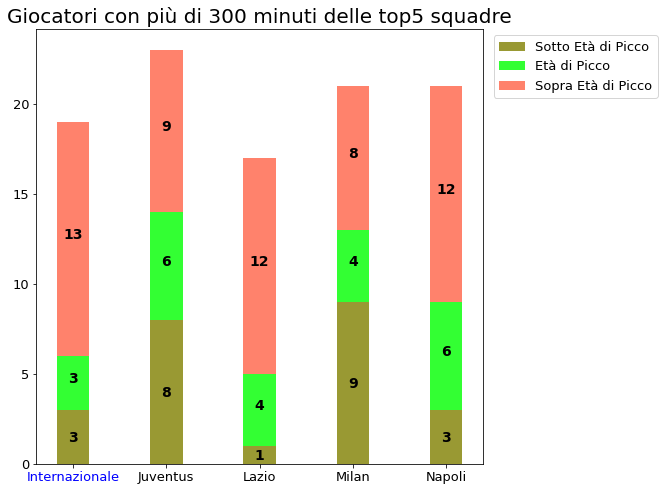

In [84]:
#prendo solo le top5 squadre
team = bb[bb.Team.isin(squadre_)]["Team"].unique()

plt.figure(figsize=(8,8))

#per ogni fascia d'età, prendo il numero di giocatori delle top5 squadre
for i in range(1,4):
  bb[(bb.peak == i) & (bb.Team.isin(squadre_))]["opta_id"].values

#grafico
width = 0.35
plt.bar(team, bb[(bb.peak == 1) & (bb.Team.isin(squadre_))]["opta_id"].values, width, label = "Sotto Età di Picco", color= "olive", alpha = 0.8)
plt.bar(team, bb[(bb.peak == 2) & (bb.Team.isin(squadre_))]["opta_id"].values, width, bottom = bb[(bb.peak == 1) & (bb.Team.isin(squadre_))]["opta_id"].values, label = "Età di Picco", color="lime", alpha = 0.8)
plt.bar(team, bb[(bb.peak == 3) & (bb.Team.isin(squadre_))]["opta_id"].values, width, bottom = bb[(bb.peak == 1) & (bb.Team.isin(squadre_))]["opta_id"].values + bb[(bb.peak == 2) & (bb.Team.isin(squadre_))]["opta_id"].values,
        label= "Sopra Età di Picco", color="tomato", alpha = 0.8)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.title("Giocatori con più di 300 minuti delle top5 squadre", fontsize = 20)
plt.gca().get_xticklabels()[0].set_color("blue")
plt.legend(bbox_to_anchor= (1.01,1), fontsize = 13)

#annoto il numero di giocatore per ogni fascia d'età e per ogni squadra
for i in range(len(team)):
      plt.annotate(bb[(bb.peak == 1) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i], xy =([i, bb[(bb.peak == 1) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i]/2 -0.3]), weight = "bold", ha='center')
      plt.annotate(bb[(bb.peak == 2) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i], xy =([i, bb[(bb.peak == 1) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i] + (bb[(bb.peak == 2) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i])/2]), weight = "bold", ha='center')
      plt.annotate(bb[(bb.peak == 3) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i], xy =([i, bb[(bb.peak == 1) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i] + bb[(bb.peak == 2) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i] + (bb[(bb.peak == 3) & (bb.Team.isin(squadre_))]["opta_id"].iloc[i])/2]), weight = "bold", ha='center')

#plt.tight_layout()
plt.savefig("giocetà.jpeg")

In [85]:
#FW con più 35 anni ordinati per mintu giocati
df_part[(df_part.soccRole == "FW") & (df_part.Età > 35)].groupby(["opta_id", "full_name"]).sum().sort_values(by="mins_played", ascending = False).head(3)

,,game_id,team_id,opp_team_id,match_day,mins_played,touches,xG,npxG,opxG,xA,...,Sprinting Distance OTIP,HI Distance OTIP,Count HSR OTIP,Count Sprint OTIP,Count HI OTIP,Count Medium Acceleration OTIP,Count High Acceleration OTIP,Count Medium Deceleration OTIP,Count High Deceleration OTIP,matchday
opta_id,full_name,,,,,,,,,,,,,,,,,,,,,
42544,Edin Dzeko,80247197,4572,18973.0,686,2475,1223.0,14.627154,14.627154,11.368025,3.420988,...,1400.0,7386.0,477.0,68.0,545.0,716.0,41.0,604.0,121.0,686
44346,Olivier Giroud,64644543,3480,14404.0,648,1902,741.0,10.159684,8.596186,5.678344,1.844655,...,1775.0,7993.0,536.0,93.0,629.0,547.0,44.0,444.0,166.0,648
12473,Fabio Quagliarella,73559958,19899,13290.0,627,1658,724.0,4.259178,3.477429,3.108259,1.837090,...,671.0,4339.0,353.0,36.0,389.0,492.0,21.0,410.0,78.0,627
